# Segmentez des clients d'un site e-commerce

<img src="logo_OLIST.png" alt="logo_OLIST" width="300" class="center"/>

# Première Partie - Exploration

# 1) Préambule

## 1.1) Problématique de l'entreprise

Olist est la plus grande plateforme de e-commerce du Brésil. Ses vendeurs partenaires ont accès à un outil de vente leur apportant visibilité et accès à de multiples solutions logistiques. 

L'entreprise nous a missionné pour travailler sur la segmentation des clients finaux utilisateurs de la plateforme. Cette segmentation est à visée marketing et permettra aux équipes de personnaliser et d'affiner les campagnes de communication.

Afin de répondre à la problématique l'entreprise nous avons :
- analysé le jeu de données mis à notre disposition
- testé plusieurs stratégies de segmentation autoatique
- étudié une proposition d'accompagnement à la maitenance du modèle sélectionnémps.

## 1.2) Import des librairies

In [1]:
# data manipulation
import pandas as pd  # to manipulate the dataset with dataframes
from dateutil import relativedelta
import numpy as np  # for statistics and calculations

# data visualisation
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mtick  # for format axis in percent %
from matplotlib.patches import Patch  # for custom legends
import seaborn as sns
import plotly.express as px

# missing values visualisation
import missingno as ms

# interactive displays
import ipywidgets as widgets

# files management
import os  # for folders management
import sys  # for memory management
import gc  # for memory management
from joblib import dump, load  # to make saves

# dealing with GPS points
import geopy.distance

# custom functions
import myFunctions as mf

# scikit learn

# preprocessing tools
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
)

# pipeline
from sklearn.pipeline import Pipeline

# impute
from sklearn.impute import SimpleImputer

# for classification
# metrics
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

# cross validation
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# model
from lightgbm import LGBMClassifier, LGBMRegressor

# for dimensionality reduction
from sklearn.manifold import TSNE
from openTSNE.sklearn import TSNE as openTSNE  # openTSNE (quicker)

# for clustering
# metrics
from sklearn.metrics import silhouette_score

# models
from sklearn.cluster import KMeans


# execution time
import time

start_time = time.time()

# pip list

In [2]:
# set theme
sns.set_theme(style="whitegrid")

## 1.3) Options du notebook & sauvegardes

Le jeu de données comporte plusieurs `.csv` que nous avons utilisés et modelés (pour réduire l'espace mémoire, pour l'encodage, pour les agrégats, etc.). Afin de réduire l'espace mémoire, nous effaçons au fur et à mesure les dataframes inutilisés.

La désactivation des options suivantes permet de les conserver :

In [3]:
# bools, wether or not delete memory consuming dataframes
deleteRawDfs = False
deleteLowMemDfs = False

Afin de réduire le temps d'exécution lors du développement du projet, nous avons utilisé les fonctions `dump` et `load` de `joblib`. 
Les enregistrements sont inclus dans le dossier `/mySaves`.

**Le notebook n'a pas besoin de ce dossier pour fonctionner**. Le temps d'exécution sera en revanche **plus long** lors de la première exécution.

L'option `rapidProcessing` peut être désactivée pour ignorer les sauvegardes (ou les recréer, après des modifications par exemple).

In [4]:
# create folders for savings
if not os.path.isdir("mySaves"):
    os.mkdir("mySaves")
if not os.path.isdir("mySaves/dataset_by_orders"):
    os.mkdir("mySaves/dataset_by_orders")

In [5]:
rapidProcessing = True

## 1.4) Imports des datasets

Importons tout d'abord nos datasets :

In [6]:
# import csv files
if os.path.isdir("archive"):
    # store csv names in a list
    csvNames = os.listdir("archive/")
    # create names for dataframes
    rawDfNames = [
        "customers",
        "geolocs",
        "orders",
        "items",
        "payments",
        "reviews",
        "products",
        "sellers",
        "translations",
    ]
    # initiate a dictionnary to store dataframes
    rawDfDict = {}

    # import each csv and store it in the dictionnary
    for csvName, rawDfName in zip(csvNames, rawDfNames):
        vars()[rawDfName] = pd.read_csv("archive/" + csvName)
        rawDfDict[rawDfName] = vars()[rawDfName]
# if folder missing, print :
else:
    print("attention le dossier de base contenant les .csv du projet n'est pas présent")

# 2) dTypes

Nous allons dans un premier optimiser l'espace mémoire utilisé par nos features. Pour cela nous utilisons la fonction `bestDtype` :

## 2.1) dTypes - Memory managament

In [7]:
# Convert dtypes to save memory usage

# create new dataframes names
lowMemDfNames = ["lowMem" + rawDfName.capitalize() for rawDfName in rawDfNames]

# initiate a dictionnary to store dataframes
lowMemDfDict = {}

# optimize memory usage
for lowMemDfName, df in zip(lowMemDfNames, rawDfDict.values()):
    # create a copy
    vars()[lowMemDfName] = df.copy()
    # use bestDtype function on each feature
    for col in df.columns:
        vars()[lowMemDfName][col] = df[col].astype(mf.bestDtype(df[col]))
    # store lowMem dataframe in the dictionnary
    lowMemDfDict[lowMemDfName] = vars()[lowMemDfName]

## 2.2) dTypes - memory space comparison

Comparons l'espace mémoire avant et après optimisation :

In [8]:
# compare memory usage, before and after

# create a dataframe
memoryComparison = pd.DataFrame(index=rawDfNames)

# compute memory usages with sys.getsizeof() for each dataset,
# before,
memoryComparison["rawImports"] = [
    sys.getsizeof(rawDfDict[rawDfName]) for rawDfName in rawDfNames
]
# and after
memoryComparison["lowMemory"] = [
    sys.getsizeof(lowMemDfDict[lowMemDfName]) for lowMemDfName in lowMemDfNames
]

# add the difference, normalized
memoryComparison["difference"] = (
    (memoryComparison["lowMemory"] / memoryComparison["rawImports"] - 1) * 100
).astype(int).astype(str) + " %"

In [9]:
memoryComparison

rawImports  lowMemory difference
customers       31060010   23537862      -24 %
geolocs        153182803   23905202      -84 %
orders          61833750   26801247      -56 %
items           41342714   19168754      -53 %
payments        18679981   12522692      -32 %
reviews         44823214   31777025      -29 %
products         7124794    6007145      -15 %
sellers           691007     429576      -37 %
translations       10604      14954       41 %

Nous pouvons maintenant supprimer les imports initiaux (si l'option est choisie) :

In [10]:
# delete raw dataframes if needed
if deleteRawDfs == True:
    del rawDfDict
    gc.collect()
    for rawDfName in rawDfNames:
        del vars()[rawDfName]
        gc.collect()

# 3) Commençons l'Exploration & le Nettoyage

Commençons l'exploration :

## 3.1) `.describe()` et `.head()` - caractériques de chaque colonne

Regardons les features à notre disposition avec la fonction `myDescribe` :

In [11]:
mf.myDescribe(lowMemDfDict)

Dropdown(description='Which dataframe :', options=('lowMemCustomers', 'lowMemGeolocs', 'lowMemOrders', 'lowMem…

Output()

In [12]:
mf.myHead(lowMemDfDict)

Dropdown(description='Which dataframe :', options=('lowMemCustomers', 'lowMemGeolocs', 'lowMemOrders', 'lowMem…

Output()

Nous n'allons pas détailler chaque colonnes. Mais nous pouvons noté quelques éléments intéressants :
- `customers` :
    - nous renseigne sur la localisation de chaque client, via :
        - `customer_city`
        - `customer_state`
        - `customer_zip_code_prefix`, que l'on pourrait assimiler à des codes postaux. Le dtype déterminé précédemment ne convient pas. **Nous le corrigerons**.
    - nous donne 2 identifiants différents par client. **Afin de regrouper nos datasets, nous étudierons par la suite ces identifiants**.
- `sellers` :
    - nous renseigne sur la localisation des vendeurs, de la même manière que dans `customers`
- `geolocs` :
    - possède lui aussi les colonnes `zip_code`, `state` et `city`, mais cette fois ci reliées à des coordonnées gps
    - à noter que le nombre de villes ou d'états uniques diffère d'un dataset à l'autre. **Nous étudierons cela.**
- `orders` :
    - possède majoritairement des colonnes **temporelles**, avec dans l'ordre :
        - l'achat
        - la validation de la commande
        - la prise en charge par le transporteur
        - la livraison
        - la livraison estimée
    - a également une colonne catégorielle `order_status` nous informant sur le statut de la commande. **Elle pourrait être considérée comme ordinale**.
- `items` :
    - nous informe sur les commandes (`order_id`), sur le prix des articles `price` ainsi que le prix de la livraison `freight_value`
    - les `order_id` ne sont pas uniques. Ce dataset nous informe donc plutôt sur chaque article article commandé, et une commande peut en contenir plusieurs. La commande `8272b63d03f5f79c56e9e4120aec44ef`, la plus fréquente, revient par exemple 21 fois.
    - `order_item_id` semble être un identifiant interne à chaque commande en cas de commande de plusieurs articles. On apprend par exemple qu'il y a 1,2 articles par commande en moyenne. le maximum est 21 : qui doit alors correspondre à la commande `8272b63d03f5f79c56e9e4120aec44ef`.
    - possède une colonne temporelle `shipping_limit_date` correspondant à la date limite d'envoi de l'article
 
- `products` et `translations` :
    - il semble manquer 2 traductions. **Nous allons corriger cela**.
    - il y a 73 catégories différentes. **On pourrait peut-être simplifier cela ?**
    - nous avons les dimensions en cm de chaque produit. Notre étude se concentrant sur les clients, nous n'aurons pas besoin de ce niveau de détail. **Nous faisons le choix de remplacer celles-ci par leut produit**.
 
- `reviews` :
    - `review_comment_title` et `review_comment_message` ont beaucoup de valeurs manquantes. **Nous n'en ferons pas l'étude.**

Nous allons corriger cela directement :

## 3.2) `xxx_city`, `xxx_state` - Des différences de formatage ?

Comme nous l'avons vu précédemment, les colonnes de `xxx_city` (ou `xxx_state`) n'ont pas nécessairement le même nombre de valeurs uniques entre datasets.
Cela pourrait s'expliquer bien sûr par le fait que les vendeurs et les clients ne sont nécessairement dans les mêmes lieux, mais regardons tout de même si certaines des ces divergences peuvent s'expliquer par des différences de formattage.

Tout d'abord, avons-nous des caractères spéciaux habituellement utilisés pour séparer les mots ?

In [13]:
# check if special characters _-()/\| are in 'xxx_city' columns

# first iterate own each concerned dataframe
for df in [lowMemCustomers, lowMemSellers, lowMemGeolocs]:
    # then find 'city' or 'state' columns
    locCols = [col for col in df.columns if ("city" in col) or ("state" in col)]
    # find values with special characters
    for col in locCols:
        print(col, ":")
        specialVals = [v for v in df[col].unique() for sc in "_-(/\|:" if sc in v]
        print(specialVals)
        print("-" * 30)

customer_city :
['varre-sai', 'mogi-guacu', 'pariquera-acu', 'xique-xique', 'embu-guacu', 'cipo-guacu', 'guajara-mirim', 'ji-parana', 'ceara-mirim', 'sapucai-mirim', 'xangri-la', 'guarda-mor', 'biritiba-mirim', 'nao-me-toque', 'governador dix-sept rosado', 'entre-ijuis', 'igarape-acu', "pingo-d'agua", 'igarape-miri', 'mogi-mirim', 'tome-acu']
------------------------------
customer_state :
[]
------------------------------
seller_city :
['lages - sc', 'auriflama/sp', 'sao paulo / sao paulo', 'cariacica / es', 'sao paulo - sp', 'sbc/sp', "arraial d'ajuda (porto seguro)", 'santo andre/sao paulo', 'sp / sp', 'maua/sao paulo', 'mogi das cruzes / sp', 'rio de janeiro \\rio de janeiro', 'barbacena/ minas gerais', 'andira-pr', 'rio de janeiro / rio de janeiro', 'pinhais/pr', 'ribeirao preto / sao paulo', 'carapicuiba / sao paulo', 'sao sebastiao da grama/sp', 'jacarei / sao paulo']
------------------------------
seller_state :
[]
------------------------------
geolocation_city :
['embu-guacu'

Seules les villes sont concernées, où l'on remarque alors plusieurs cas :
- `"-"` : après quelques recherches, dans ces cas il s'agit le plus souvent de mots composés
- `")"` ou `"("` : il s'agit dans ces cas de précisions
- `" - "` ou `"/"` ou `" / "`, etc. : dans ces cas l'état est précisé après la ville. Nous sommes alors face à un problème de formattage.

Nous allons gérer cela :

In [14]:
# just keep the first part of a city if it contains " / ", "/ ", " /", "/", " - "

# iterate on datasets
for df in [lowMemCustomers, lowMemSellers, lowMemGeolocs]:
    # find 'city' columns
    cityCols = [col for col in df.columns if ("city" in col)]
    for col in cityCols:
        # use .str.split(expand=True) to split the column using a "problem" as separator, and keep only the first part
        for pb in [" / ", "/ ", " /", "/", " - "]:
            df[col] = df[col].str.split(pb, expand=True)[0]
            # put back the column type to category
            df[col] = df[col].astype("category")

Notons qu'il existe aussi des différences dues à des accents, au sein même des colonnes :

## 3.3) `xxx_city`, `xxx_state` - Suppression des accents

Nous utilisons la function `removeAccent` :

In [15]:
# removes accents

# first iterate own each concerned dataframe
for df in [lowMemCustomers, lowMemSellers, lowMemGeolocs]:
    # then find 'city' or 'state' columns
    locCols = [col for col in df.columns if ("city" in col) or ("state" in col)]
    for col in locCols:
        # use custom function mf.removeAccent
        df[col] = df[col].apply(
            lambda x: mf.removeAccent(x) if type(x) == str else np.nan
        )
        # put back the column type to category
        df[col] = df[col].astype("category")

## 3.4) `review_comment_title`,`review_comment_message` - suppression

Comme vu précédemment, nous supprimons ces features :

In [16]:
# drop "review_comment_title" and "review_comment_message"
lowMemReviews.drop(
    columns=["review_comment_title", "review_comment_message"], inplace=True
)

## 3.5) `order_status` - ordinale ?

Regardons les catégories de `order_status` :

In [17]:
lowMemOrders["order_status"].value_counts(dropna=False)

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Nous pouvons considérer ces différentes étapes dans l'ordre suivant :

In [18]:
# list of unique "order_status" values, ordered :
order_status_order = [
    "canceled",
    "created",
    "approved",
    "processing",
    "unavailable",
    "invoiced",
    "shipped",
    "delivered",
]

In [19]:
# set dtype from categorical to ordered categorical, using order_status_order
lowMemOrders["order_status"] = pd.Categorical(
    lowMemOrders["order_status"], categories=order_status_order, ordered=True
)

## 3.6) `product_category_name` - catégories manquantes

Regardons quelles catégories sont concernées par une abscence de traduction :

In [20]:
# look for missing categories in Translations
categoriesFromTranslation = lowMemTranslations["product_category_name"].unique()
categoriesFromProducts = lowMemProducts[
    "product_category_name"
].cat.categories.to_list()
diff = set(categoriesFromProducts).difference(set(categoriesFromTranslation))
diff

{'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

Il ne nous reste plus qu'à les rajouter :

In [21]:
# add missing translations
newRows = pd.DataFrame(
    [
        ["pc_gamer", "pc_gamer"],
        [
            "portateis_cozinha_e_preparadores_de_alimentos",
            "portable_kitchen_and_food_preparation_devices",
        ],
    ],
    columns=lowMemTranslations.columns,
)

lowMemTranslations = pd.concat([lowMemTranslations, newRows])

# update Translations dataframe in the dictionnary
lowMemDfDict["lowMemTranslations"] = lowMemTranslations

## 3.7) Remplacer `product_length_cm`, `product_height_cm`, `product_width_cm` par `product_volume_m3`

In [22]:
# find "_cm" columns
sizeCols = [col for col in lowMemProducts.columns if "_cm" in col]

# create a "volume" feature
lowMemProducts["product_volume_m3"] = lowMemProducts[sizeCols].prod(axis=1) / 100**3

# drop "_cm" features
lowMemProducts.drop(columns=sizeCols, inplace=True)

# 4) Colonnes "id"

Étudions un peu les différents identifiants présents. En effet, afin de traiter au mieux nos données, nous allons essayer de fusionner les différents datasets en un seul. Les identifiants permettront d'avoir une clé commune entre 2 datasets pour effectuer la jointure.

## 4.1) Colonnes "id" - les identifier

Commençons par identifier les `id` et adaptons leur dtype pour être compatible avec les fonctions de jointure.

In [23]:
# create a list of "id" columns
idColNames = [
    col
    for df in lowMemDfDict.values()
    for col in df.columns
    if (("_id" in col) or ("_zip_code_prefix" in col))
]

# drop duplicates
idColNames = list(set(idColNames))

# adapt dtype for .merge() compatibility
for df in lowMemDfDict.values():
    for col in df.columns:
        if (col in idColNames) and (df[col].dtype.kind in "iu"):
            print(col)
            df[col] = df[col].astype("int64")

customer_zip_code_prefix
geolocation_zip_code_prefix
order_item_id
seller_zip_code_prefix


## 4.2) Colonnes "id" - des doublons ?

Regardons tout d'abord si ces identifiants sont uniques :

In [24]:
# look for "id" duplicates

# initiate a dataframe to store the number of duplicates
idsDupliDf = pd.DataFrame()

# one row per "id" feature, one columns per dataset
for dfName, df in lowMemDfDict.items():
    for col in df.columns:
        if col in idColNames:
            # compute the number of duplicates
            idsDupliDf.loc[col, dfName] = df[col].duplicated().sum()

In [25]:
idsDupliDf

lowMemCustomers  lowMemGeolocs  lowMemOrders  \
customer_id                              0.0            NaN           0.0   
customer_unique_id                    3345.0            NaN           NaN   
customer_zip_code_prefix             84447.0            NaN           NaN   
geolocation_zip_code_prefix              NaN       981148.0           NaN   
order_id                                 NaN            NaN           0.0   
order_item_id                            NaN            NaN           NaN   
product_id                               NaN            NaN           NaN   
seller_id                                NaN            NaN           NaN   
review_id                                NaN            NaN           NaN   
seller_zip_code_prefix                   NaN            NaN           NaN   

                             lowMemItems  lowMemPayments  lowMemReviews  \
customer_id                          NaN             NaN            NaN   
customer_unique_id                   NaN             NaN            NaN   
customer_zip_code_prefix             NaN             NaN            NaN   
geolocation_zip_code_prefix          NaN             NaN            NaN   
order_id                         13984.0          4446.0          551.0   
order_item_id                   112629.0             NaN            NaN   
product_id                       79699.0             NaN            NaN   
seller_id                       109555.0             NaN            NaN   
review_id                            NaN             NaN          814.0   
seller_zip_code_prefix               NaN             NaN            NaN   

                             lowMemProducts  lowMemSellers  
customer_id                             NaN            NaN  
customer_unique_id                      NaN            NaN  
customer_zip_code_prefix                NaN            NaN  
geolocation_zip_code_prefix             NaN            NaN  
order_id                                NaN            NaN  
order_item_id                           NaN            NaN  
product_id                              0.0            NaN  
seller_id                               NaN            0.0  
review_id                               NaN            NaN  
seller_zip_code_prefix                  NaN          849.0

Ce que l'on peut en retenir :
- les `customer_id` sont uniques dans `customers` et `orders`
- les `customer_unique_id` ne sont pas uniques. Il semblerait que :
    - un `customer_id` soit généré à chaque commande, peu importe que le client soit nouveau ou régulier
    - un `customer_unique_id` unique soit attribué à chaque client
- les `order_id` sont uniques dans `orders`, mais pas dans `items`, `payments` et `reviews`. En effet il peut y avoir :
    - plusieurs produits par commande
    - des paiments avec différents moyens
    - plusieurs commentaires par commande
- les `order_item_id` ont évidemment des doublons car cette numérotation est toujours la même à chaque commande.
- les `geolocation_zip_code_prefix`, seule manière de relier les coordonnées GPS au reste des données clients et vendeurs, ont des doublons.

## 4.3) Colonnes "id" - Identifier le niveau de correspondance entre les datasets

Regardons maintenant si les valeurs prises par les colonnes de type "id" sont les mêmes entre les datasets :

In [26]:
# identify the level of correspondence between the datasets

# initiate a dataframe
idDf = pd.DataFrame()

# extract 'SK_ID_xx' columns from main datasets
orderIdsList = lowMemOrders.order_id.to_list()
custumerIdsList = lowMemOrders.customer_id.to_list()
sellerIdsList = lowMemSellers.seller_id.to_list()
productIdsList = lowMemProducts.product_id.to_list()
zipCodeIdsList = lowMemGeolocs.geolocation_zip_code_prefix.to_list()
zipCodeIdsList = list(set(zipCodeIdsList))

# iterate on datasets
for lowMemDfName, df in lowMemDfDict.items():
    # iterate on ...
    for idCol, idList, lowMemDfNameBis in zip(
        [
            "order_id",
            "customer_id",
            "seller_id",
            "product_id",
            "zip_code_prefix",
        ],  # ... 'id's names
        [
            orderIdsList,
            custumerIdsList,
            sellerIdsList,
            productIdsList,
            zipCodeIdsList,
        ],  # ... 'id's columns in main datasets
        [
            "Orders",
            "Custumers",
            "Sellers",
            "Products",
            "Geolocs",
        ],  # ... main datasets names
    ):
        # create a column for the mean number of rows for this idCol
        if "nRows_Per_" + idCol not in idDf.columns:
            idDf["nRows_Per_" + idCol] = pd.Series(dtype="O")
        else:
            idDf["nRows_Per_" + idCol] = idDf["nRows_Per_" + idCol].astype("O")

        # create a column for the level of correspondence with the main datasets
        if "%InterWith" + lowMemDfNameBis not in idDf.columns:
            idDf["%InterWith" + lowMemDfNameBis] = pd.Series(dtype="O")
        else:
            idDf["%InterWith" + lowMemDfNameBis] = idDf[
                "%InterWith" + lowMemDfNameBis
            ].astype("O")

        # if this "id" columns exists in this df (here we actually replace "xxx_zip_code_prefix" by "zip_code_prefix")
        if idCol in [
            col if "zip_code_prefix" not in col else "zip_code_prefix"
            for col in df.columns
        ]:
            # get the real name of the column (takes care of the "zip_code_prefix"s, which have different names)
            idColReal = [col for col in df.columns if idCol in col][0]
            # compute the average number of duplicates
            idDf.loc[lowMemDfName, "nRows_Per_" + idCol] = round(
                df[idColReal].value_counts().mean(), 1
            )
            # compute the level of correspondence with the main datasets
            # and put it in percent
            idDf.loc[lowMemDfName, "%InterWith" + lowMemDfNameBis] = (
                str(
                    int(
                        round(
                            len(set(idList).intersection(df[idColReal].to_list()))
                            / len(idList)
                            * 100,
                            0,
                        )
                    )
                )
                + "%"
            )  # % of matching 'id'

# add multi indexing for columns
idDf.columns = [
    np.array(
        [
            e
            for e in [
                "order_id",
                "customer_id",
                "seller_id",
                "product_id",
                "zip_code_prefix",
            ]
            for i in range(2)
        ]
    ),
    np.array(idDf.columns),
]

In [27]:
idDf

order_id                            customer_id  \
                nRows_Per_order_id %InterWithOrders nRows_Per_customer_id   
lowMemCustomers                NaN              NaN                   1.0   
lowMemGeolocs                  NaN              NaN                   NaN   
lowMemOrders                   1.0             100%                   1.0   
lowMemItems                    1.1              99%                   NaN   
lowMemPayments                 1.0             100%                   NaN   
lowMemReviews                  1.0              99%                   NaN   
lowMemProducts                 NaN              NaN                   NaN   
lowMemSellers                  NaN              NaN                   NaN   

                                              seller_id                    \
                %InterWithCustumers nRows_Per_seller_id %InterWithSellers   
lowMemCustomers                100%                 NaN               NaN   
lowMemGeolocs                   NaN                 NaN               NaN   
lowMemOrders                   100%                 NaN               NaN   
lowMemItems                     NaN                36.4              100%   
lowMemPayments                  NaN                 NaN               NaN   
lowMemReviews                   NaN                 NaN               NaN   
lowMemProducts                  NaN                 NaN               NaN   
lowMemSellers                   NaN                 1.0              100%   

                          product_id                     \
                nRows_Per_product_id %InterWithProducts   
lowMemCustomers                  NaN                NaN   
lowMemGeolocs                    NaN                NaN   
lowMemOrders                     NaN                NaN   
lowMemItems                      3.4               100%   
lowMemPayments                   NaN                NaN   
lowMemReviews                    NaN                NaN   
lowMemProducts                   1.0               100%   
lowMemSellers                    NaN                NaN   

                          zip_code_prefix                    
                nRows_Per_zip_code_prefix %InterWithGeolocs  
lowMemCustomers                       6.6               78%  
lowMemGeolocs                        52.6              100%  
lowMemOrders                          NaN               NaN  
lowMemItems                           NaN               NaN  
lowMemPayments                        NaN               NaN  
lowMemReviews                         NaN               NaN  
lowMemProducts                        NaN               NaN  
lowMemSellers                         1.4               12%

L'object est d'apporter des informations supplémentaires au fichier **clients** pour réaliser notre segmentation. **La série de jointure pour regrouper les datasets privilégiera  donc `custumers`**. 

On apprend que les jointures généreront des valeurs manquantes correspondant aux identifiants du dataframe privilégié qui ne sont pas présents dans le dataset source (par exemple, lorsque nous effectuerons la jointure de `items` sur `orders`, autour de 1% de valeurs manquantes seront ajoutées.)

# 5) Unifier nos datasets

## 5.1) Unifier nos datasets, stratégie

Nous avons deux solutions pour regrouper nos datasets en un seul :
1) soit **le faire directement** sans prendre en compte les doublons. Dans ce cas ces doublons généreront des valeurs dupliquées dans le dataset cible afin de contenir chaque ligne unique du dataset source. Il faudra alors **traiter ces doublons par la suite** via des agrégations (`.groupby()`)
2) soit effectuer des **agrégations sur chaque dataset** pris **individuellement**, **avant de gérer nos jointures**.

Dans notre cas nous utiliserons la 2ème méthode. 

### 1 - agrégations puis jointures pour obtenir des `order_id` uniques :


**`zip_code` :**

Aggrégations sur les `geolocation_zip_code_prefix` dans :
- `geolocs`

Puis jointures en utilisant `zip_code_prefix` :
- `geolocs` --> `customers`
- `geolocs` --> `sellers`

**`seller_id` :** 

Jointure :
- `sellers (+ geolocs)` --> `items`

**`product_category_name` :**

Jointure :
- `translation` --> `products`

**`product_id` :**

Jointure :
- `products(+ translations)` --> `items`

**`order_id` :**

Aggrégations sur les `order_id` dans :
- `items (+ products + translations + sellers + geolocs)`
- `payments`
- `reviews`

Puis jointures :
- `items (+ products + translations + sellers + geolocs)` --> `orders`
- `payments` --> `orders`
- `reviews` --> `orders`



### 2 - jointure avec le dataset `customers` :

**`customer_id` :**

Jointure :
- `orders (+ items + products + translations + sellers + geolocs + payments + reviews)` --> `customers (+ geolocs)`

Nous pourrons ainsi étudier le dataset obtenu, notamment par `customer_unique_id` pour effectuer notre segmentation clients :

### 3 - agrégations sur les `customer_unique_id`

## 5.2) Unifier nos datasets, mise en oeuvre

In [28]:
# merging style, we will always focus on the informations of the left dataframe
myHow = "left"

### 5.2.1) Agrégations `geolocs`

In [29]:
# aggregate "geolocs" on "geolocation_zip_code_prefix"

# use the mean of GPS coords and the mode of cities and states
# in a dictionnary
aggDict = {
    "geolocation_lat": ["mean"],
    "geolocation_lng": ["mean"],
    "geolocation_city": [mf.myMode],
    "geolocation_state": [mf.myMode],
}

# use .groupby
geolocsGB = lowMemGeolocs.groupby(
    "geolocation_zip_code_prefix", as_index=False, observed=True
).agg(aggDict)

# correct columns index
geolocsGB.columns = pd.Index(e[0] for e in geolocsGB.columns)

### 5.2.2) Jointure `geolocs` dans `customers` (*grâce à `zip_code_prefix`*)

In [30]:
# merge Customers informations with geolocs, using their "custumer_zip_code_prefix"
customersGeo = pd.merge(
    left=lowMemCustomers,
    left_on="customer_zip_code_prefix",
    right=geolocsGB,
    right_on="geolocation_zip_code_prefix",
    how=myHow,
)

Regardons les valeurs manquantes :

In [31]:
# missing values of 'customersGeo' using nanTab function
mf.nanTab(customersGeo, digits=3)

NaN_rate
customer_id                    0.0 %
customer_unique_id             0.0 %
customer_zip_code_prefix       0.0 %
customer_city                  0.0 %
customer_state                 0.0 %
geolocation_zip_code_prefix   0.28 %
geolocation_lat               0.28 %
geolocation_lng               0.28 %
geolocation_city              0.28 %
geolocation_state             0.28 %

Nous voyons que la jointure a généré des valeurs manquantes sur les colonnes issues de `geolocs` : des code postaux de `customer_zip_code_prefix` inconnus dans `geolocation_zip_code_prefix`.

Cette jointure a également généré des **colonnes redondantes** au niveau de :
- `zip_code`
- `city`
- `state`

Nous allons explorer ces colonnes pour :
- décider laquelle conserver
- tirer le maximum de ces colonnes avant de les supprimer

Tout d'abord, et comme ce cas arrivera plusieurs fois, écrivons une fonction pour l'exploration :

In [32]:
def exploreDupliCols(df, dupliCols):
    """
    a custom function to explore the differences between columns of a dataframe that should be equivalent
    parameters :
    ------------
    df - dataframe
    dupliCols - list of tuples of strings : a list a duplicated columns names, each pair of duplicates is in a tuple

    returns :
    --------
    dupliColsExploreDf - dataframe : a tab containing informations on each pair : Number of differences, missing values rate, and an example
    """

    # create a dataframe to store informations
    dupliColsExploreDf = pd.DataFrame(
        columns=["Nb_notMatchRows", "example", "%NaN_col1", "%NaN_col2"], dtype="O"
    )

    # iterate on duplicated columns
    for col1, col2 in dupliCols:
        # store columns in s1 and s2
        s1 = df[col1].copy()
        s2 = df[col2].copy()

        # adjust dtype if cols are categorical
        for s in [s1, s2]:
            if s.dtype.kind == "O":
                s = s.astype("O")

        # filter on row where s1 and s2 are different, and not NaN
        comparDf = df[[col1, col2]].loc[
            ((s1 != s2) & (df[[col1, col2]].notna().all(axis=1)))
        ]

        # store the number of differences
        dupliColsExploreDf.loc[col1 + " / " + col2, "Nb_notMatchRows"] = len(comparDf)

        # store an example of different values
        if len(comparDf) > 0:
            dupliColsExploreDf.loc[col1 + " / " + col2, "example"] = str(
                comparDf.sample(random_state=3).iloc[0].values
            )
        else:
            dupliColsExploreDf.loc[col1 + " / " + col2, "example"] = np.nan

        # store the NaN rate
        dupliColsExploreDf.loc[col1 + " / " + col2, "%NaN_col1"] = (
            round(s1.isna().mean() * 100, 2).astype(str) + " %"
        )
        dupliColsExploreDf.loc[col1 + " / " + col2, "%NaN_col2"] = (
            round(s2.isna().mean() * 100, 2).astype(str) + " %"
        )

        del s1, s2, comparDf
        gc.collect()

    return dupliColsExploreDf

In [33]:
# list of duplicates
dupliColsCustomersGeo = [
    ("customer_zip_code_prefix", "geolocation_zip_code_prefix"),
    ("customer_city", "geolocation_city"),
    ("customer_state", "geolocation_state"),
]
# use custom function
dupliColsCustomersGeoExploreDf = exploreDupliCols(
    df=customersGeo, dupliCols=dupliColsCustomersGeo
)

display(dupliColsCustomersGeoExploreDf)

Nb_notMatchRows  \
customer_zip_code_prefix / geolocation_zip_code...               0   
customer_city / geolocation_city                               170   
customer_state / geolocation_state                               0   

                                                                                  example  \
customer_zip_code_prefix / geolocation_zip_code...                                    NaN   
customer_city / geolocation_city                    ['arraial d ajuda' "arraial d'ajuda"]   
customer_state / geolocation_state                                                    NaN   

                                                   %NaN_col1 %NaN_col2  
customer_zip_code_prefix / geolocation_zip_code...     0.0 %    0.28 %  
customer_city / geolocation_city                       0.0 %    0.28 %  
customer_state / geolocation_state                     0.0 %    0.28 %

Pour les colonnes identiques (c'est à dire avec 0 observations différentes), nous **conservevons celle ayant le moins de valeurs manquantes**. Nous allons donc nous séparer de :
- `geolocation_zip_code_prefix`
- `geolocation_state`

In [34]:
customersGeo.drop(
    columns=["geolocation_zip_code_prefix", "geolocation_state"], inplace=True
)

Pour ce qui est des colonnes `customer_city` et `geolocation_city`, nous allons **conserver** `geolocation_city` afin de **rester cohérent avec les autres données** issues de `geolocs`, notamment les coordonnées GPS. Mais avant cela, nous allons **nous servir de** `customer_city`, comportant moins de valeurs manquantes, **pour imputer** `geolocation_city` ainsi que les autres colonnes issus de `geolocs`, qui comportent des valeurs manquantes dues à la jointure.

In [35]:
def useDupliColToImput(df, dupliCol, dupliColToImput, otherColsToImput=[]):
    """
    a custom function to impute columns of a dataframe using a pair of duplicated columns, one helping to impute the other

    parameters :
    ------------
    df - dataframe
    dupliCol - string : the categorical column used to impute
    dupliColToImput - string : the column we want to impute
    otherColsToImput - list of strings : other columns we want to impute. By default : []

    """

    # a first mask to filter on rows where we don't know dupliColToImput, but we know dupliCol
    mask1 = df[dupliColToImput].isna() & df[dupliCol].notna()
    # another to focus only on rows where we have both
    mask2 = df[[dupliCol, dupliColToImput]].notna().all(axis=1)

    # list of column names we are using dupliCol to impute with
    colsToImpute = [dupliColToImput] + otherColsToImput

    # filter row wise on mask2 to iterate on each dupliCol unique values
    for value in df.loc[mask2, dupliCol].unique():
        # a third mask to filter on rows where dupliCol is equal to value
        mask3 = df[dupliCol] == value
        # iterate on each column of colsToImpute
        for colToImp in colsToImpute:
            # if the column to impute is categorical
            # we impute the values of this column where we know that dupliCol==value (i.e. using mask1 and mask3)
            # with the column's mode where the value of dupliCol is also value (i.e. using mask2 and mask3)
            if df[colToImp].dtype.kind == "O":
                df.loc[mask1 & mask3, colToImp] = (
                    df.loc[mask2 & mask3, colToImp].value_counts().index[0]
                )
            # if the column to impute is numerical, we use the same method with the mean
            else:
                df.loc[mask1 & mask3, colToImp] = df.loc[mask2 & mask3, colToImp].mean()

Imputons `geolocation_city`,`geolocation_lat`, `geolocation_lng` :

In [36]:
# use custom function to impute "geolocation_city",'geolocation_lat','geolocation_lng'
useDupliColToImput(
    df=customersGeo,
    dupliCol="customer_city",
    dupliColToImput="geolocation_city",
    otherColsToImput=["geolocation_lat", "geolocation_lng"],
)

Nous pouvons maintenant comparer :

In [37]:
# missing values of 'customersGeo' using nanTab function
mf.nanTab(customersGeo, digits=3)

NaN_rate
customer_id                 0.0 %
customer_unique_id          0.0 %
customer_zip_code_prefix    0.0 %
customer_city               0.0 %
customer_state              0.0 %
geolocation_lat           0.052 %
geolocation_lng           0.052 %
geolocation_city          0.052 %

Nous avons réduit le nombre de valeurs manquantes (0.28% --> 0.052%). Celles restantes correspondent à des codes postaux et des villes ne figurant pas dans `geolocs`. Nous pouvons maintenant nous séparer de `customer_city` :

In [38]:
customersGeo.drop(columns=["customer_city"], inplace=True)

### 5.2.3) Jointures `geolocs` dans `sellers` (*grâce à `zip_code_prefix`*)

Nous allons utiliser le même principe :

In [39]:
# merge 'sellers' informations with 'geolocs', using their "seller_zip_code_prefix"
sellersGeo = pd.merge(
    left=lowMemSellers,
    left_on="seller_zip_code_prefix",
    right=geolocsGB,
    right_on="geolocation_zip_code_prefix",
    how=myHow,
)

# delete 'geolocsGB'
del geolocsGB
gc.collect()

0

Regardons les valeurs manquantes :

In [40]:
# missing values of 'customersGeo' using nanTab function
mf.nanTab(sellersGeo, digits=3)

NaN_rate
seller_id                      0.0 %
seller_zip_code_prefix         0.0 %
seller_city                    0.0 %
seller_state                   0.0 %
geolocation_zip_code_prefix  0.226 %
geolocation_lat              0.226 %
geolocation_lng              0.226 %
geolocation_city             0.226 %
geolocation_state            0.226 %

Et procédons de la même manière que précédemment.
D'abord en analysant les colonnes redondantes :

In [41]:
# list of duplicates
dupliColsSellersGeo = [
    ("seller_zip_code_prefix", "geolocation_zip_code_prefix"),
    ("seller_city", "geolocation_city"),
    ("seller_state", "geolocation_state"),
]
# use custom function
dupliColsSellersGeoExploreDf = exploreDupliCols(
    df=sellersGeo, dupliCols=dupliColsSellersGeo
)

display(dupliColsSellersGeoExploreDf)

Nb_notMatchRows  \
seller_zip_code_prefix / geolocation_zip_code_p...               0   
seller_city / geolocation_city                                  92   
seller_state / geolocation_state                                35   

                                                                                              example  \
seller_zip_code_prefix / geolocation_zip_code_p...                                                NaN   
seller_city / geolocation_city                      ['santa barbara d oeste' "santa barbara d'oeste"]   
seller_state / geolocation_state                                                          ['SP' 'PR']   

                                                   %NaN_col1 %NaN_col2  
seller_zip_code_prefix / geolocation_zip_code_p...     0.0 %    0.23 %  
seller_city / geolocation_city                         0.0 %    0.23 %  
seller_state / geolocation_state                       0.0 %    0.23 %

Supprimons `geolocation_zip_code_prefix` (pas de différence avec `seller_zip_code_prefix` et plus de NaN) :

In [42]:
sellersGeo.drop(columns=["geolocation_zip_code_prefix"], inplace=True)

Imputons `geolocation_city`,`geolocation_lat`, `geolocation_lng` et `geolocation_state` :

In [43]:
# use custom function to impute "geolocation_city",'geolocation_lat','geolocation_lng','geolocation_state'
useDupliColToImput(
    df=sellersGeo,
    dupliCol="seller_city",
    dupliColToImput="geolocation_city",
    otherColsToImput=["geolocation_lat", "geolocation_lng", "geolocation_state"],
)

Nous pouvons maintenant comparer :

In [44]:
# missing values of 'customersGeo' using nanTab function
mf.nanTab(sellersGeo, digits=3)

NaN_rate
seller_id                 0.0 %
seller_zip_code_prefix    0.0 %
seller_city               0.0 %
seller_state              0.0 %
geolocation_lat           0.0 %
geolocation_lng           0.0 %
geolocation_city          0.0 %
geolocation_state         0.0 %

Nous avons été plus chanceux ici, nous n'avons plus de valeurs manquantes. Nous pouvons maintenant nous séparer de `seller_city` :

In [45]:
# drop the seller "state" column which have more mistakes and is less precise
sellersGeo.drop(columns="seller_city", inplace=True)

Pour ce qui est des `seller_state / geolocation_state`, nous avons 35 incohérences. Afin de faire notre choix, nous allons **nous focaliser sur les observations différentes** et :
- regarder les **différentes valeurs prises par chacune d'elle**
- étudier **quelques échantillons**

In [46]:
# focus on "seller_state" / "geolocation_state" differences and look at the counts of each state

# columns in a list
stateCitySellerCols = ["geolocation_city", "seller_state", "geolocation_state"]

# create a mask : differences AND non NaN rows
mask = (sellersGeo["seller_state"] != sellersGeo["geolocation_state"]) & sellersGeo[
    stateCitySellerCols
].notna().all(axis=1)

# filter data and display "xxx_state" columns value_counts :
display(sellersGeo.loc[mask, "seller_state"].astype("O").value_counts().to_frame())
display(sellersGeo.loc[mask, "geolocation_state"].value_counts().to_frame())

# same filter, this time to make a sample
display(sellersGeo.loc[mask, stateCitySellerCols].sample(5, random_state=16))

count
seller_state       
SP               33
RN                1
PA                1

count
geolocation_state       
PR                    11
SC                     7
MG                     6
RJ                     5
RS                     3
ES                     1
BA                     1
DF                     1

geolocation_city seller_state geolocation_state
2646    boa esperanca           SP                RJ
424         tocantins           SP                MG
1819         londrina           SP                PR
2455         blumenau           SP                SC
364    rio de janeiro           SP                RJ

Lorsqu'ils ne sont pas identiques, les états renseignés dans `geolocation_state` **sont plus diversifiés** que ceux de `seller_state`.

De plus, après avoir regarder la localisation des villes de l'échantillon, les états de `geolocation_state` étaient **à chaque fois les bons**.

Nous décidons donc de **conserver uniquement `geolocation_state`**.

In [47]:
# drop the seller "state" column which have more mistakes and is less precise
sellersGeo.drop(columns="seller_state", inplace=True)

### 5.2.4) Jointure `sellers (+ geolocs)` dans `items` (*grâce à `seller_id`*)

In [48]:
# merge 'sellersGeo' and 'items'
itemsSellersGeo = pd.merge(
    left=lowMemItems, right=sellersGeo, on="seller_id", how=myHow
)

del sellersGeo
gc.collect()

0

### 5.2.5) Jointure `translations` dans `products` (*grâce à `product_category_name`*)

In [49]:
# merge 'sellersGeo' and 'items'
productsTrans = pd.merge(
    left=lowMemProducts, right=lowMemTranslations, on="product_category_name", how=myHow
)

De la même manière, nous venons de créer des colonnes redondantes : `product_category_name` et `product_category_name_english`. Nous gardons la version anglaise :

In [50]:
productsTrans.drop(columns="product_category_name", inplace=True)

### 5.2.6) Jointure `products (+ translations)` dans `items (+ sellers + geolocs)` (*grâce à `product_id`*)

In [51]:
# merge 'productsTrans' and 'itemsSellersGeo'
itemsSellersGeoProductsTrans = pd.merge(
    left=itemsSellersGeo, right=productsTrans, on="product_id", how=myHow
)

del itemsSellersGeo, productsTrans
gc.collect()

0

### 5.2.7) Agrégations `items (+ products + translations + sellers + geolocs)` sur les `order_id`

Ici, avant d'agréger, nous allons trier `itemsSellersGeoProductsTrans` en fonction de `price` : En effet nous allons garder pour chaque commande la `product_category_name_english` la plus fréquente. Trier préalablement par `price` nous permettra de conserver l'article le plus cher dans le cas où plusieurs articles serait achetés le même nombre de fois.

In [52]:
# aggregation dictionnary
aggDict = {
    "order_id": [],
    "order_item_id": ["max"],
    "product_id": ["nunique"],
    "seller_id": [],
    "shipping_limit_date": ["max"],
    "price": ["mean"],
    "freight_value": ["mean"],
    "seller_zip_code_prefix": [mf.myMode],
    "geolocation_lat": ["mean"],
    "geolocation_lng": ["mean"],
    "geolocation_city": [mf.myMode],
    "geolocation_state": [mf.myMode],
    "product_name_lenght": [],
    "product_description_lenght": [],
    "product_photos_qty": [],
    "product_weight_g": ["max"],
    "product_volume_m3": ["mean"],
    # 'product_length_cm': ["max"],
    # 'product_height_cm': ["max"],
    # 'product_width_cm': ["max"],
    "product_category_name_english": [
        mf.myMode
    ],  # carefull : has missing values, myMode handles it :  "missing_values"
}

# use .groupby, but first sort by 'price'
itemsSellersGeoProductsTransGB = (
    itemsSellersGeoProductsTrans.sort_values("price", ascending=False)
    .groupby("order_id", as_index=False, observed=True)
    .agg(aggDict)
)

# correct columns index
itemsSellersGeoProductsTransGB.columns = pd.Index(
    e[0] for e in itemsSellersGeoProductsTransGB.columns
)
# for "order_item_id", "product_id", be more specific
itemsSellersGeoProductsTransGB.rename(
    columns={"order_item_id": "n_items", "product_id": "n_unique_items"}, inplace=True
)

### 5.2.8) Agrégations `payments` sur les `order_id`

Ici, avant d'agréger, nous allons trier `payments` en fonction de `payment_value`. Cela nous permettra de garder le `payment_type` le plus important pour chaque commande `order_id`. 

In [53]:
# aggregation dictionnary
aggDict = {
    "order_id": [],
    "payment_sequential": ["max"],
    "payment_type": ["first"],
    "payment_installments": ["max"],
    "payment_value": ["sum"],
}

# use .groupby, but first sort by 'payment_value'
paymentsGB = (
    lowMemPayments.sort_values("payment_value", ascending=False)
    .groupby("order_id", as_index=False, observed=True)
    .agg(aggDict)
)

# correct columns index
paymentsGB.columns = pd.Index(e[0] for e in paymentsGB.columns)

### 5.2.9) Agrégations `reviews` sur les `order_id`

Ici, avant d'agréger, nous allons trier `reviews` en fonction de la `review_creation_date`. Cela nous permettra de garder la note `review_score` la plus récente pour chaque commande `order_id`. 

In [54]:
# aggregation dictionnary
aggDict = {
    "review_id": ["count"],
    "order_id": [],
    "review_score": ["first"],
    "review_creation_date": [],
    "review_answer_timestamp": [],
}

# use .groupby, but first sort by 'review_creation_date'
reviewsGB = (
    lowMemReviews.sort_values("review_creation_date", ascending=False)
    .groupby("order_id", as_index=False, observed=True)
    .agg(aggDict)
)

# correct columns index
reviewsGB.columns = ["order_id", "n_reviews", "review_score"]

### 5.2.10) Jointure `items (+ products + translations + sellers + geolocs)`, `payments` et `reviews` dans `orders` (*grâce à `order_id`*)

In [55]:
# merge 'itemsSellersGeoProductsTransGB' and 'lowMemOrders'
dataOrd = pd.merge(
    left=lowMemOrders, right=itemsSellersGeoProductsTransGB, on="order_id", how=myHow
)

# merge 'dataOrd' and 'paymentsGB'
dataOrd = pd.merge(left=dataOrd, right=paymentsGB, on="order_id", how=myHow)

# merge 'dataOrd' and 'reviewsGB'
dataOrd = pd.merge(left=dataOrd, right=reviewsGB, on="order_id", how=myHow)

del itemsSellersGeoProductsTransGB, paymentsGB, reviewsGB
gc.collect()

0

### 5.1.11) Jointure `orders (+ les autres)` dans `customers (+ geolocs)` (*grâce à `customer_id`*)

In [56]:
# merge 'customersGeo' and 'dataOrd'
dataOrd = pd.merge(
    left=customersGeo,
    right=dataOrd,
    on="customer_id",
    how=myHow,
    suffixes=("_CUS", "_SEL"),  # handle columns names duplicates
)

# rename "zip_code_prefix", "state" and "city" columns :
dataOrd.rename(
    columns={
        "customer_zip_code_prefix": "zip_code_prefix_CUS",
        "customer_state": "state_CUS",
        "geolocation_city_CUS": "city_CUS",
        "seller_zip_code_prefix": "zip_code_prefix_SEL",
        "geolocation_city_SEL": "city_SEL",
        "geolocation_state": "state_SEL",
    },
    inplace=True,
)

In [57]:
# delete lowMemxx dataframes, if needed
if deleteLowMemDfs == True:
    del lowMemDfDict
    gc.collect()
    for lowMemDfName in lowMemDfNames:
        del vars()[lowMemDfName]
        gc.collect()

# 6) Exploration du dataset des commandes (`order_id`)

Avant d'agréger nos données par client unique, nous pouvons explorer `dataOrd`.

Nous avons maintenant un unique dataframe :

In [58]:
# look at first rows of 'dataOrd'
mf.myHead(dataOrd)

BoundedIntText(value=15, description='Number of lines : ', max=60, min=1, style=DescriptionStyle(description_w…

Output()

In [59]:
# use describe()
mf.myDescribe(dataOrd)

Output()

Certains `dtypes` sont en `object` :

In [60]:
# cast `object` dtypes to "category"
for col in dataOrd.columns:
    if dataOrd[col].dtype == "object":
        dataOrd[col] = dataOrd[col].astype("category")

Les  `zip_code_prefix` ne sont pas en `category` :

In [61]:
# cast "zip"-like columns "category"
for col in [col for col in dataOrd if "zip" in col]:
    dataOrd[col] = dataOrd[col].astype("category")

Les  `n_items` et `n_unique_items` ont (très) majoritairement comme valeur 1. Nous allons imputer leurs valeurs manquantes avec cette valeur :

In [62]:
# impute "n_items","n_unique_items" with 1
for col in ["n_items", "n_unique_items", "n_reviews"]:
    dataOrd[col].fillna(dataOrd[col].median(), inplace=True)

## 6.1) Les catégories de produit

Nous avions vu plus haut qu'il pourrait être intéressant de réduire le nombre de catégories :

In [63]:
# first, impute missing values with "missing"
dataOrd["product_category_name_english"].fillna("missing", inplace=True)

In [64]:
# create a dictionary with macro categories as keys and  initial categories as values
mainCatsDict = {
    "furniture": [
        "office_furniture",
        "furniture_decor",
        "bed_bath_table",
        "kitchen_dining_laundry_garden_furniture",
        "furniture_living_room",
        "furniture_bedroom",
    ],
    "fashion": [
        "fashio_female_clothing",
        "fashion_bags_accessories",
        "fashion_male_clothing",
        "fashion_shoes",
        "fashion_underwear_beach",
        "fashion_sport",
        "fashion_childrens_clothes",
    ],
    "DIY": [
        "garden_tools",
        "construction_tools_lights",
        "home_construction",
        "costruction_tools_tools",
        "construction_tools_construction",
        "construction_tools_safety",
        "costruction_tools_garden",
    ],
    "appliances": [
        "air_conditioning",
        "home_appliances_2",
        "small_appliances",
        "small_appliances_home_oven_and_coffee",
        "home_appliances",
    ],
    "tech": [
        "computers_accessories",
        "telephony",
        "electronics",
        "tablets_printing_image",
        "computers",
        "audio",
        "pc_gamer",
    ],
    "leisure": [
        "sports_leisure",
        "art",
        "consoles_games",
        "books_general_interest",
        "musical_instruments",
        "music",
        "dvds_blu_ray",
        "books_imported",
        "books_technical",
        "cine_photo",
        "cds_dvds_musicals",
        "arts_and_craftmanship",
    ],
    "gifts": [
        "toys",
        "watches_gifts",
        "perfumery",
    ],
    "food_shopping": [
        "food_drink",
        "drinks",
        "food",
    ],
    "household_shopping": [
        "housewares",
        "health_beauty",
        "pet_shop",
        "baby",
        "stationery",
        "christmas_supplies",
        "party_supplies",
        "flowers",
        "diapers_and_hygiene",
    ],
    "equipment": [
        "home_confort",
        "auto",
        "luggage_accessories",
        "fixed_telephony",
        "portable_kitchen_and_food_preparation_devices",
        "furniture_mattress_and_upholstery",
        "la_cuisine",
        "home_comfort_2",
    ],
    "pro": [
        "signaling_and_security",
        "industry_commerce_and_business",
        "agro_industry_and_commerce",
        "security_and_services",
    ],
    "others": [
        "missing",
        "cool_stuff",
        "market_place",
    ],
}

# inverse the dictionnary
mainCatsDictInv = {cat: key for key in mainCatsDict.keys() for cat in mainCatsDict[key]}

In [65]:
# use the dictionary in .map() method
dataOrd["NEW_macro_product_category"] = (
    dataOrd["product_category_name_english"].map(mainCatsDictInv).astype("category")
)

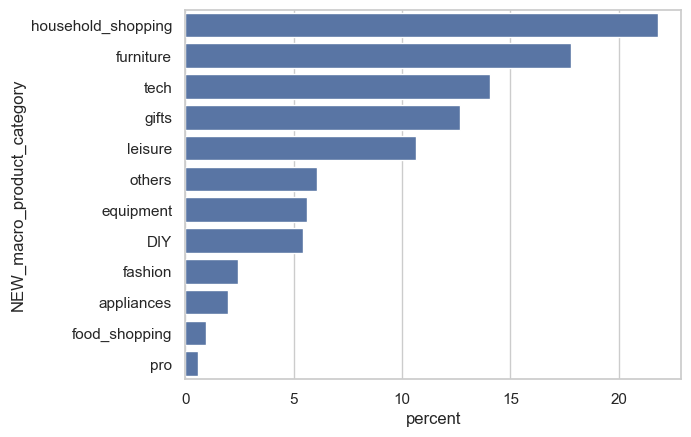

In [66]:
# plot the distribution of "NEW_macro_product_category"

# order based on value counts
myOrder = dataOrd["NEW_macro_product_category"].value_counts().index
sns.countplot(
    data=dataOrd, y="NEW_macro_product_category", order=myOrder, stat="percent"
)

plt.show()

## 6.2) Les notes clients

Une manière intéressante d'en apprendre plus sur les clients est leur niveau de satisfaction, grâce à la colonne `review_score` :

In [67]:
# set dtype to categorical
dataOrd["review_score"] = pd.Categorical(
    dataOrd["review_score"], categories=[1, 2, 3, 4, 5], ordered=True
)

# create a color palette
reviewColors = {1: "red", 2: "coral", 3: "gold", 4: "greenyellow", 5: "green"}

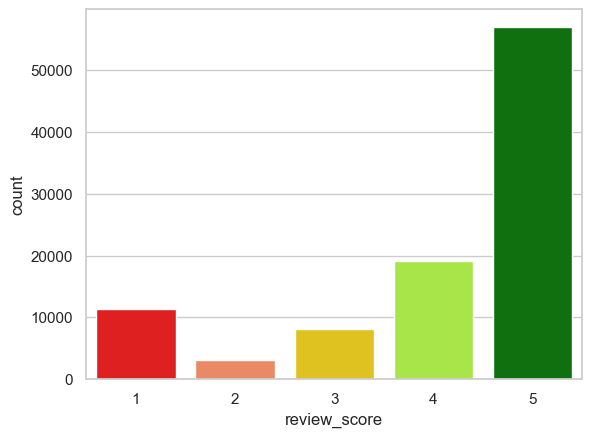

In [68]:
fig, ax = plt.subplots(1)
for score in dataOrd["review_score"].cat.categories:
    df = dataOrd.copy().loc[dataOrd["review_score"] == score]
    sns.countplot(data=df, x="review_score", color=reviewColors[score], ax=ax)
    del df
    gc.collect()

Le majorité des notes associées à chaque commande sont positives, mais il y a tout de même une bonne partie des commandes avec la note plus basse.

## 6.3) Les colonnes temporelles

### 6.3.1) Les colonnes temporelles - dans quel ordre ?

Les colonnes temporelles sont les suivantes :

In [69]:
# date columns list
timeCols = [col for col in dataOrd.columns if col if dataOrd[col].dtype.kind in "M"]
print(timeCols)

['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']


Essayons de déterminer l'ordre logique. Pour cela nous allons regarder la moyenne de chaque colonne temporelle :

In [70]:
# look at the mean of each timeSeries

# focus on not NaN row
mask = dataOrd[timeCols].notna().all(axis=1)
meanDates = dataOrd.loc[mask, timeCols].mean(axis=0).sort_values()
meanDates

order_purchase_timestamp        2018-01-01 23:53:26.642248960
order_approved_at               2018-01-02 10:10:06.480142336
order_delivered_carrier_date    2018-01-05 05:21:04.508827392
shipping_limit_date             2018-01-08 13:40:57.731041536
order_delivered_customer_date   2018-01-14 13:17:13.228102912
order_estimated_delivery_date   2018-01-25 17:33:14.236012288
dtype: datetime64[ns]

Nous avons donc à notre disposition :
- `order_purchase_timestamp` : l'achat
- `order_approved_at` : l'approbation de la commande
- `order_delivered_carrier_date` : la prise en charge du transporteur
- `shipping_limit_date` : la limite d'envoi (pour le vendeur)
- `order_delivered_customer_date` : la réception de la commande chez le client
- `review_creation_date` : la création du commentaire
- `review_answer_timestamp` : la réponse au commentaire
- `order_estimated_delivery_date` : l'estimation de la réception de la commande

In [71]:
# update timeSeries list to have proper order
timeCols = meanDates.index.to_list()

### 6.3.2) Discrétiser le mois d'achat

Afin de pouvoir étudier certaines dimensions de notre dataset de manière mensuelle ou annuelle, nous pouvons discrétiser la date d'achat `order_purchase_timestamp` :

In [72]:
# create discrete "order_purchase_timestamp" columns

# year
dataOrd["NEW_purchase_descrete_YEAR"] = pd.Categorical(
    dataOrd["order_purchase_timestamp"].dt.year, ordered=True
)
# month
dataOrd["NEW_purchase_descrete_MONTH"] = pd.Categorical(
    dataOrd["order_purchase_timestamp"].dt.year * 100
    + dataOrd["order_purchase_timestamp"].dt.month,
    ordered=True,
)

mf.myDescribe(dataOrd[["NEW_purchase_descrete_YEAR", "NEW_purchase_descrete_MONTH"]])

Output()

### 6.3.3) Chiffre d'affaires mensuel d'Olist

On peut s'intéresser alors au chiffre d'affaires annuel et mensuel d'Olist :

In [73]:
# list of columns needed for monthly revenu
neededCols = [
    # "customer_unique_id",
    "payment_value",
    "NEW_purchase_descrete_MONTH",
    "NEW_purchase_descrete_YEAR",
]

# create a copy
dataRevenues = dataOrd.copy()

# keep only needed cols
dataRevenues = dataRevenues[neededCols]

# group by unique "order_item_id" to aggregate payments made with differents methods
dataRevenuesGB = dataRevenues.groupby(
    ["NEW_purchase_descrete_YEAR", "NEW_purchase_descrete_MONTH"],
    observed=True,
    as_index=False,
).sum()

Sous forme d'un barplot, cela donne :

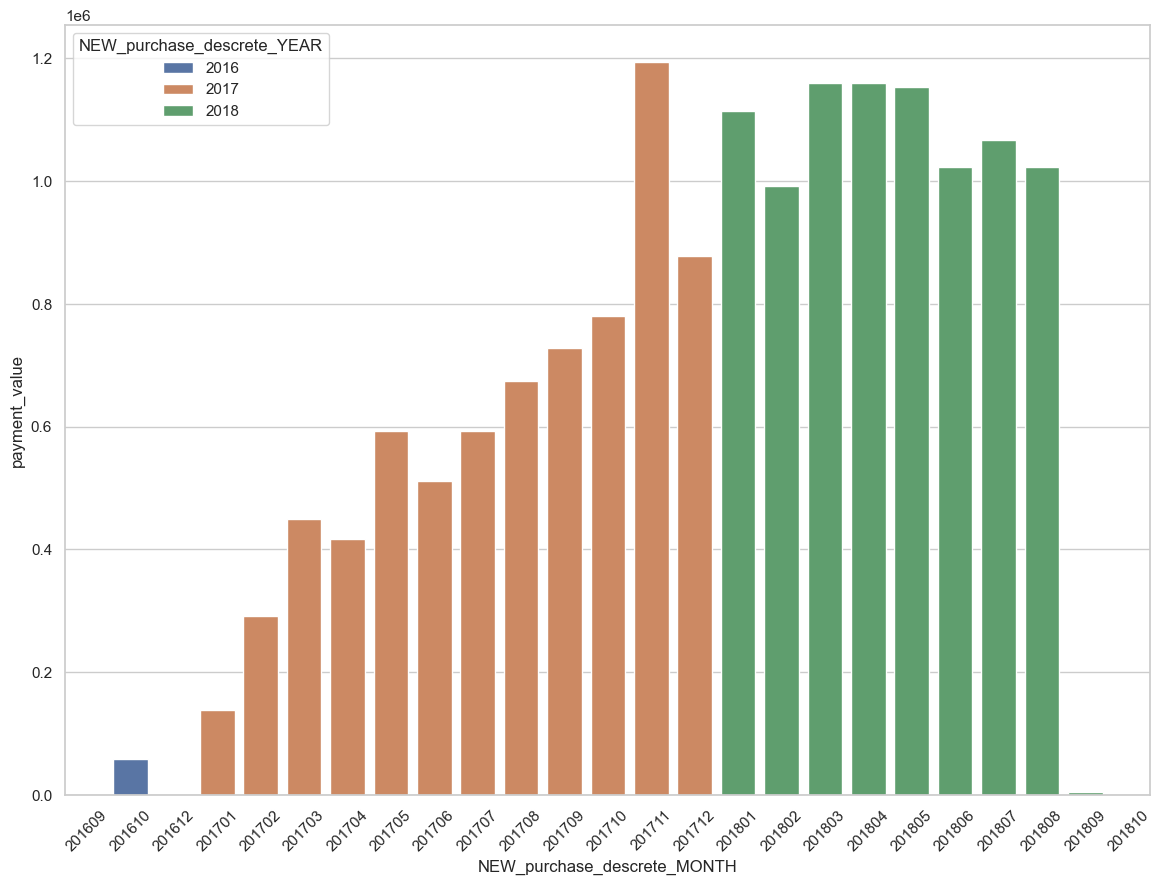

In [74]:
fig, ax = plt.subplots(1, figsize=(14, 10))
sns.barplot(
    data=dataRevenuesGB,
    x="NEW_purchase_descrete_MONTH",
    y="payment_value",
    ax=ax,
    hue="NEW_purchase_descrete_YEAR",
)
plt.xticks(rotation=45)
plt.show()

Et par an :

<Axes: xlabel='NEW_purchase_descrete_YEAR', ylabel='payment_value'>

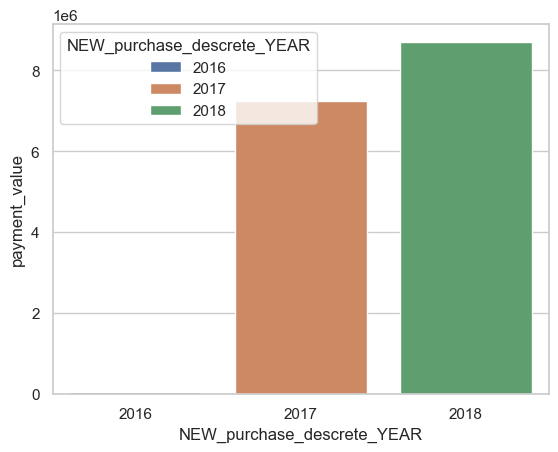

In [75]:
byYear = dataRevenuesGB.groupby(
    "NEW_purchase_descrete_YEAR", observed=True, as_index=False
)["payment_value"].sum()
sns.barplot(
    data=byYear,
    x="NEW_purchase_descrete_YEAR",
    y="payment_value",
    hue="NEW_purchase_descrete_YEAR",
)

### 6.3.4) Sur quelle période nos données sont-elles étalées ?

In [76]:
# store the oldest and the most recent dates, and the time between them
maxDate = dataOrd[timeCols].max().max().date()
minDate = dataOrd[timeCols].min().min().date()
diffRelative = relativedelta.relativedelta(maxDate, minDate)

print("Données collectées de ", maxDate, "à", minDate, ".")
print("-" * 30)
print(
    "Sur",
    diffRelative.years,
    "ans,",
    diffRelative.months,
    "mois et",
    diffRelative.days,
    "jours.",
)

Données collectées de  2020-04-09 à 2016-09-04 .
------------------------------
Sur 3 ans, 7 mois et 5 jours.


A la vue de cette période, une **échelle de temps mensuelle semble être pertinente** pour analyser les autres données (comme le chiffres d'affaire ou le nombre de commandes, etc.) au cours du temps.

### 6.3.5) Les valeurs manquantes, lien avec le `order_status`

Regardons les valeurs manquantes de notre colonnes temporelles :

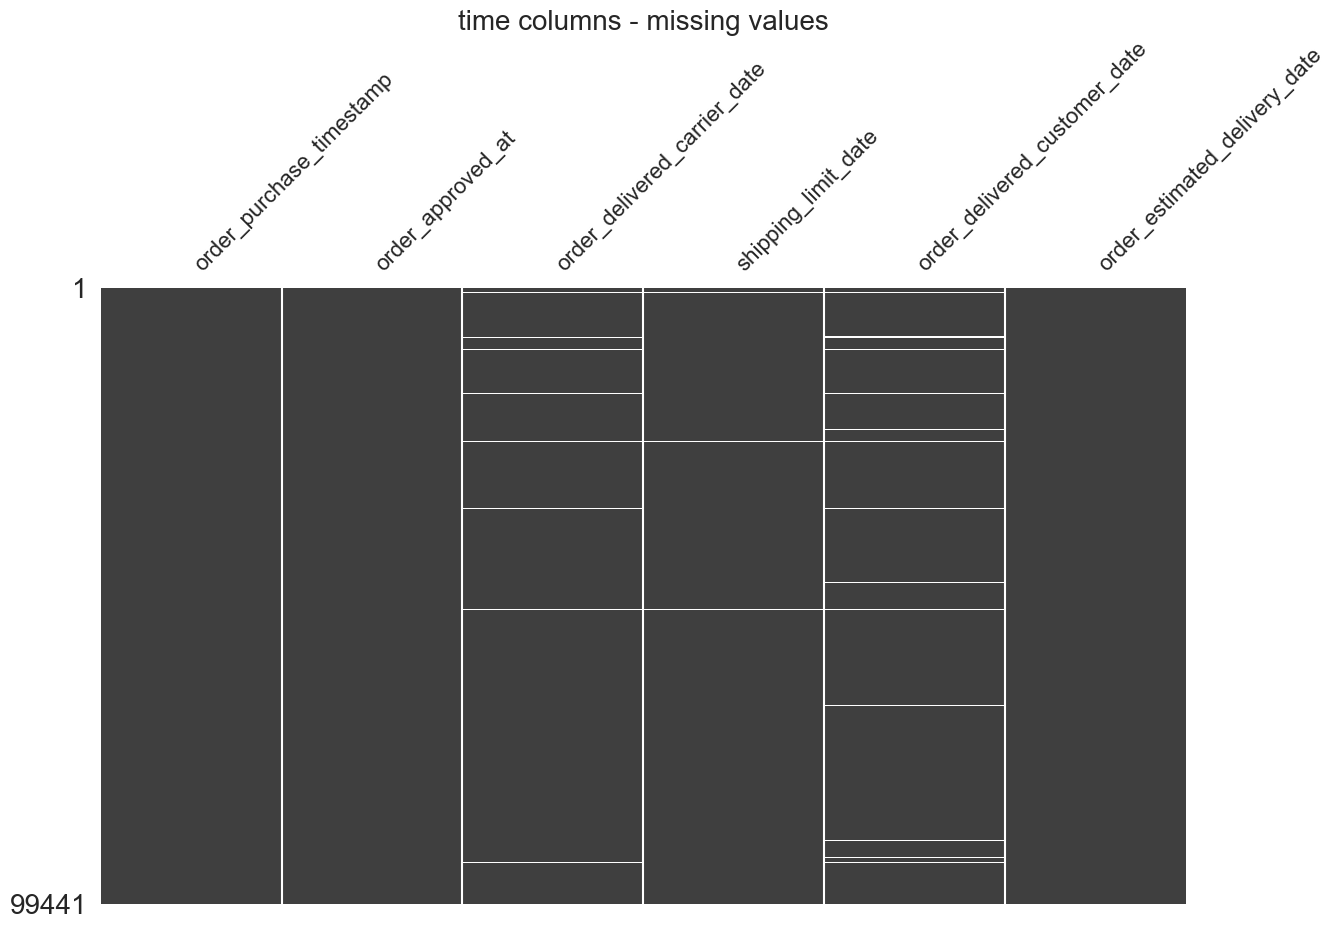

In [77]:
# use missingno matrix function

fig, ax = plt.subplots(1, figsize=(14, 8))
ms.matrix(dataOrd[timeCols], ax=ax, sparkline=False)
ax.set_title("time columns - missing values", size=20)
plt.show()

Il y a l'air d'y avoir plusieurs cas. Par exemple :
- `order_approved_at` manquante ; alors les autres le sont aussi
- `order_delivered_carrier_date` manquante ; alors `order_delivered_customer` l'est aussi
- etc.

Regardons cela de plus près grâce à une fonction :

In [78]:
def exploreTimeColsNans(
    approved=None,
    carrier=None,
    customer=None,
    interestingCols=timeCols + ["order_status", "payment_value", "review_score"],
):
    """
    custom fonction to filter dataOrd on different cases :
            - missing
            - not missing
            - any (no filtering)
    for different columns :
            - "order_approved_at"
            - "order_delivered_carrier_date"
            - "order_delivered_customer_date"

    parameters :
    approved - bool or NoneType : for "order_approved_at" column, True --> not missing, False --> missing, None --> any. By default, None.
    carrier - bool or NoneType : same for "order_delivered_carrier_date"
    customer - bool or NoneType : same for "order_delivered_customer_date"

    output :
    displays :
        dataOrd filtered (5 rows, random)
        number of unique values of "order_status"

    """
    # initiate a mask for filtering
    maskS = dataOrd.notna().any(axis=1)
    # list of inputs and columns names :
    inputList = [approved, carrier, customer]
    colList = [
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
    ]
    # for each column, update maskS, given its input
    for input, col in zip(inputList, colList):
        if input == False:
            maskS = maskS & dataOrd[col].isna()
        elif input == True:
            maskS = maskS & dataOrd[col].notna()

    # filter
    filteredOrd = dataOrd.loc[maskS]

    # print the number of rows of the filtered dataOrd
    print("Nb of orders : " + str(len(filteredOrd)))

    # display 5 sampled rows of filteredOrd (if possible)
    display(filteredOrd[interestingCols].sample(min(5, len(filteredOrd))))

    # display "order_status" value_counts()
    display(filteredOrd["order_status"].value_counts().to_frame())

Nous allons explorer les différents cas de figure :

In [79]:
# use widgets to test different combinations on our function exploreTimeColsNans

# for "order_approved_at"
widApproved = widgets.RadioButtons(
    options={"any": None, "NaN": False, "not NaN": True},
    description=" 'order_approved_at' : ",
)

# for "order_delivered_carrier_date"
widCarrier = widgets.RadioButtons(
    options={"any": None, "NaN": False, "not NaN": True},
    description=" 'order_delivered_carrier_date' : ",
)

# for "order_delivered_customer_date"
widCustomer = widgets.RadioButtons(
    options={"any": None, "NaN": False, "not NaN": True},
    description=" 'order_delivered_customer_date' : ",
)

# create an ui with previous radio buttons
ui = widgets.HBox([widApproved, widCarrier, widCustomer])

# use interactive_output on exploreTimeColsNans function
out = widgets.interactive_output(
    exploreTimeColsNans,
    {"approved": widApproved, "carrier": widCarrier, "customer": widCustomer},
)
display(ui, out)

Output()

Nous avons les possibilités suivantes :

In [80]:
# create a table with possible combinations
pd.DataFrame(
    {
        "order_approved_at": [1, 1, 1, 0, 1, 0, 0],
        "order_delivered_carrier_date": [1, 1, 0, 1, 0, 1, 0],
        "order_delivered_customer_date": [1, 0, 1, 1, 0, 0, 1],
    }
).map(lambda x: {1: "Not NaN", 0: "NaN"}[x])

order_approved_at order_delivered_carrier_date order_delivered_customer_date
0           Not NaN                      Not NaN                       Not NaN
1           Not NaN                      Not NaN                           NaN
2           Not NaN                          NaN                       Not NaN
3               NaN                      Not NaN                       Not NaN
4           Not NaN                          NaN                           NaN
5               NaN                      Not NaN                           NaN
6               NaN                          NaN                       Not NaN

Cas **3** et **6**  : toutes ces commandes ont bien été livrées. Pour ces cas, nous pouvons imputer `order_approved_at`avec la valeur de `order_purchase_timestamp`.

Cas **5** : pas de commande concernée

In [81]:
# impute 'order_approved_at' when 'order_delivered_customer_date' is notNaN with the value of 'order_purchase_timestamp'
mask = (
    dataOrd["order_approved_at"].isna()
    & dataOrd["order_delivered_customer_date"].notna()
)
dataOrd.loc[mask, "order_approved_at"] = dataOrd.loc[mask, "order_purchase_timestamp"]

Cas **2** : toutes ces commandes ont bien été livrées. Pour ces cas, nous pouvons imputer `order_delivered_carrier_date`avec la valeur de `shipping_limit_date`.

In [82]:
# impute 'order_delivered_carrier_date' when 'order_delivered_customer_date' is notNaN with the value of 'shipping_limit_date'
mask = (
    dataOrd["order_delivered_carrier_date"].isna()
    & dataOrd["order_delivered_customer_date"].notna()
)
dataOrd.loc[mask, "order_delivered_carrier_date"] = dataOrd.loc[
    mask, "shipping_limit_date"
]

Cas **0** : la grande partie de ces commandes ont été tout simplement **annulées**... **Ces commandes ne peuvent pas vraiment être comptabilisées.**

Cas **1** : ici, la plupart d'entre elles sont notés comme `shipped`, mais n'ont apparemment pas été livrées... **Ces commandes ne peuvent pas vraiment être comptabilisées.**

Cas **4** : ici, les commandes sont soit `unavailable`, `canceled`, `invoiced`, ou `processing` , mais n'ont apparemment pas été livrées... **Ces commandes ne peuvent pas vraiment être comptabilisées.**

Aparté : il y a quelques cas où la commande est `delivered` avec une `order_delivered_customer_date` manquante :

In [83]:
# filter on "delivered" orders without 'order_delivered_customer_date'
mask = (dataOrd["order_status"] == "delivered") & (
    dataOrd["order_delivered_customer_date"].isna()
)
dataOrd.loc[mask, timeCols + ["order_status", "payment_value", "review_score"]]

order_purchase_timestamp   order_approved_at  \
9034       2018-06-20 06:58:43 2018-06-20 07:19:05   
12030      2018-06-27 16:09:12 2018-06-27 16:29:30   
13357      2018-07-01 17:05:11 2018-07-01 17:15:12   
51668      2017-11-28 17:44:07 2017-11-28 17:56:40   
85377      2018-06-08 12:09:39 2018-06-08 12:36:39   
87172      2018-07-01 22:05:55 2018-07-01 22:15:14   
89194      2018-07-01 21:14:02 2018-07-01 21:29:54   
97677      2017-05-25 23:22:43 2017-05-25 23:30:16   

      order_delivered_carrier_date shipping_limit_date  \
9034           2018-06-25 08:05:00 2018-06-26 07:19:05   
12030          2018-07-03 19:26:00 2018-07-03 16:29:30   
13357          2018-07-03 13:57:00 2018-07-05 17:15:12   
51668          2017-11-30 18:12:23 2017-12-04 17:56:40   
85377          2018-06-12 14:10:00 2018-06-18 12:30:35   
87172          2018-07-03 13:57:00 2018-07-05 22:15:14   
89194          2018-07-03 09:28:00 2018-07-05 21:29:54   
97677                          NaT 2017-06-04 23:30:16   

      order_delivered_customer_date order_estimated_delivery_date  \
9034                            NaT                    2018-07-16   
12030                           NaT                    2018-07-19   
13357                           NaT                    2018-07-30   
51668                           NaT                    2017-12-18   
85377                           NaT                    2018-06-26   
87172                           NaT                    2018-07-30   
89194                           NaT                    2018-07-24   
97677                           NaT                    2017-06-23   

      order_status  payment_value review_score  
9034     delivered         354.24            5  
12030    delivered          54.97            5  
13357    delivered         158.07            5  
51668    delivered         134.83            5  
85377    delivered         120.12            1  
87172    delivered         158.07            5  
89194    delivered         204.62            5  
97677    delivered         194.00            5

In [84]:
# impute 'order_delivered_carrier_date' with median pick-up time
pickUpTime = (
    dataOrd["order_delivered_carrier_date"] - dataOrd["order_purchase_timestamp"]
).dt.days.median()
dataOrd.loc[97677, "order_delivered_carrier_date"] = dataOrd.loc[
    97677, "order_purchase_timestamp"
] + pd.Timedelta(days=pickUpTime)

# impute 'order_delivered_customer_date' with median delivery time
deliveryTime = (
    dataOrd["order_delivered_customer_date"] - dataOrd["order_delivered_carrier_date"]
).dt.days.median()
dataOrd.loc[mask, "order_delivered_customer_date"] = dataOrd.loc[
    mask, "order_delivered_carrier_date"
] + pd.Timedelta(days=deliveryTime)

Revenons aux cas **0**, **1** et **4**. Nous avons vu que ces commandes ne sont pas vraiment à prendre en compte. **Mais attention, certaines de ces commandes sont peut-être tout simplement très récentes...** Rapprochons-nous de la commande la plus tardive de notre dataset et donnons-nous 31 jours de battement (pour prendre en compte la livraison de façon large). Il y a peut-être des commandes en cours de traitement :

In [85]:
# filter on recent orders, neither "delivered" nor "canceled"

# first, get the most recent purchase date
maxPurchaseDate = dataOrd["order_purchase_timestamp"].max()

# then filter
mask = (
    (dataOrd["order_purchase_timestamp"] > (maxPurchaseDate - pd.Timedelta(days=31)))
    & (dataOrd["order_status"] != "delivered")
    & (dataOrd["order_status"] != "canceled")
)

dataOrd.loc[mask, timeCols + ["order_status"]]

Empty DataFrame
Columns: [order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, shipping_limit_date, order_delivered_customer_date, order_estimated_delivery_date, order_status]
Index: []

Il ne semble pas y avoir de commandes suffisament récentes pour que sa livraison n'est pas eu le temps d'être prise en compte.

Créons deux colonnes binaires nous permettant de repérer ces trois types :
- livrée
- annulée
- autre

In [86]:
# create a column to flag if an order has been delivered
dataOrd["NEW_delivered"] = dataOrd["order_status"] == "delivered"
# create a column to flag if an order has been canceled
dataOrd["NEW_canceled"] = dataOrd["order_status"] == "canceled"
# create a column to flag if an order has had an issue
dataOrd["NEW_issue"] = ~dataOrd["order_status"].isin(["canceled", "delivered"])

### 6.3.6) Des retards de livraison ?

On peut s'intéresser aux éventuelles retards de livraison, et au décallage en règle général entre dates de livraison estimée et réelle.

Commençons par comparer `order_delivered_customer_date` à `order_estimated_delivery_date` :

In [87]:
# create a column with the number of days late in delivery
diff = (
    dataOrd["order_delivered_customer_date"] - dataOrd["order_estimated_delivery_date"]
).dt.ceil("d")
# convert to numerical
diff = diff.dt.days.astype("float")
# optimise dtype
diff = diff.astype(mf.bestDtype(diff))

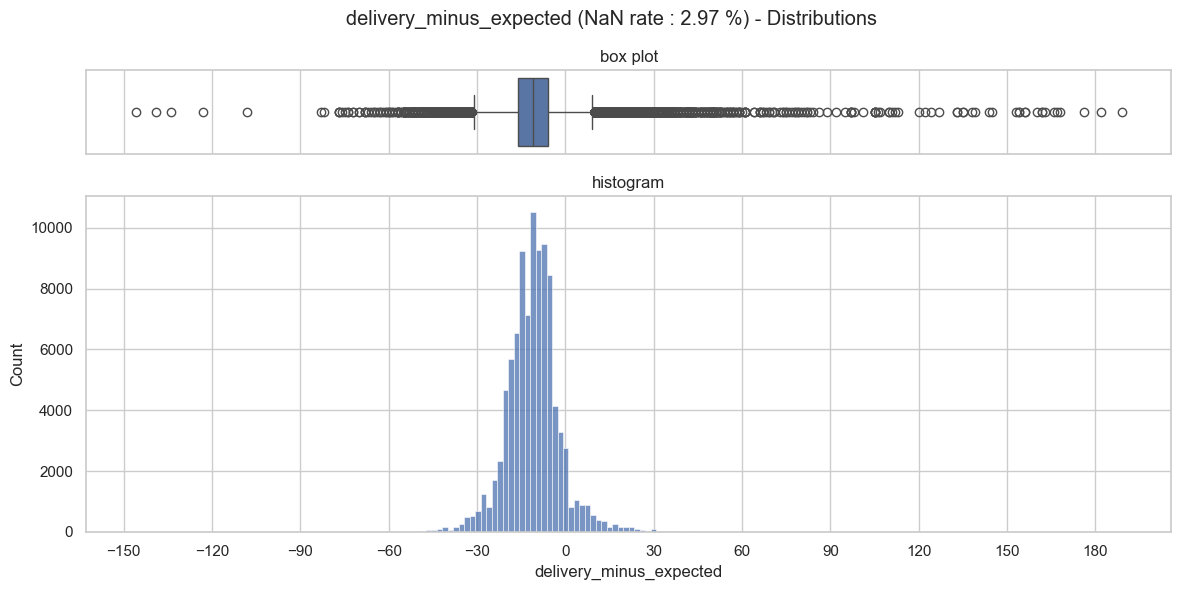

In [88]:
# draw two distributions of this difference : a histogram and a boxplot

# put diff in a dataframe
diff_df = diff.to_frame(name="delivery_minus_expected")

# add review to diff_df
diff_df["review_score"] = dataOrd["review_score"].copy()

# create fig and both axes, a smaller one for the boxplot
fig, (ax_box, ax_hist) = plt.subplots(
    2, 1, sharex=True, height_ratios=(1, 4), figsize=(14, 6)
)

# plot
sns.histplot(data=diff_df, x="delivery_minus_expected", bins=180, ax=ax_hist)
sns.boxplot(data=diff_df, x="delivery_minus_expected", ax=ax_box)

# set xticks
ax_hist.set_xticks(np.arange(-150, 210, step=30))

# titles

# put NaN_rate in the title
nanRate = round(diff.isna().mean() * 100, 2)
fig.suptitle(
    "delivery_minus_expected (NaN rate : " + str(nanRate) + " %) - Distributions"
)
ax_box.set_title("box plot")
ax_hist.set_title("histogram")

plt.show()

Il y a des **valeurs extrêmes** dans les deux sens ... On peut imaginer différentes hypothèses pour expliquer cela  :
- en retard :
    - un colis extrêmement en retard...
    - une **erreur de mesure** sur la date de livraison effective `order_delivered_customer_date`
    - une date de livraison `order_estimated_delivery_date` **estimée trop optimiste**
- en avance :
    - un colis extrêmement en avance...
    - une date de livraison `order_estimated_delivery_date` **estimée trop pessimite**

On peut s'interroger sur la relation entre le retard de livraison `NEW_lateDeliveryDays` et la note attribuée à la commande `review_score` :

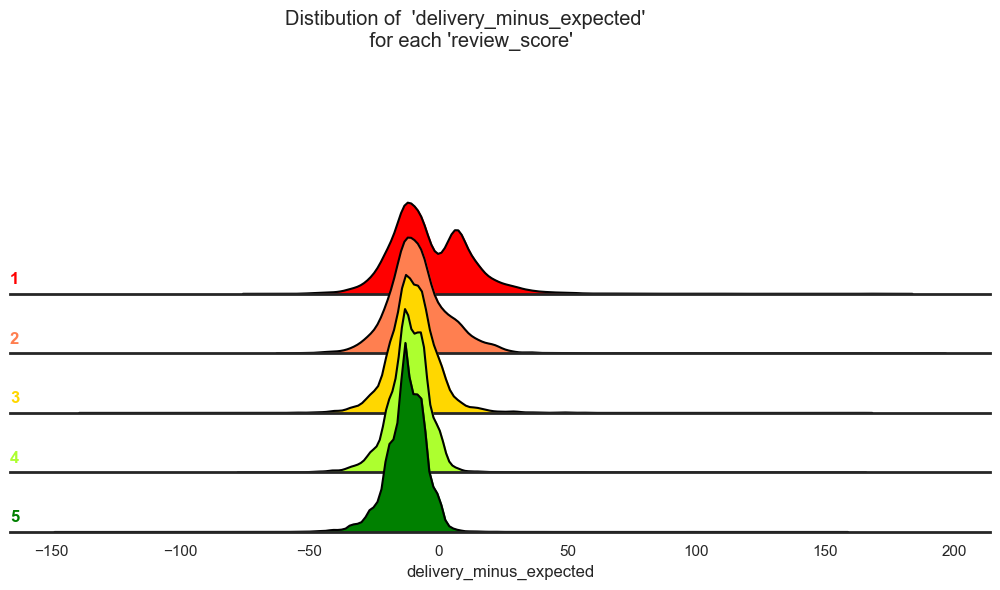

In [89]:
# use custom fonction distribRidgePlot
mf.distribRidgePlot(
    df=diff_df,
    categFeatureName="review_score",
    numFeatureName="delivery_minus_expected",
    # zoomInterval=[-30,30],
    # clip=(-29,30),
    overlap=0.7,
    palette=reviewColors,
)
# the previous fonction changes seaborn theme params, reset them
sns.set_theme(style="whitegrid")

Parmis les commandes avec de mauvaises notes, il y a bien en effet **plus** de commandes avec un retard de livraison. **Mais les outliers perturbent les distributions**. Une autre manière de représenter cela est en utilisant un graphique en "barres empilées" :

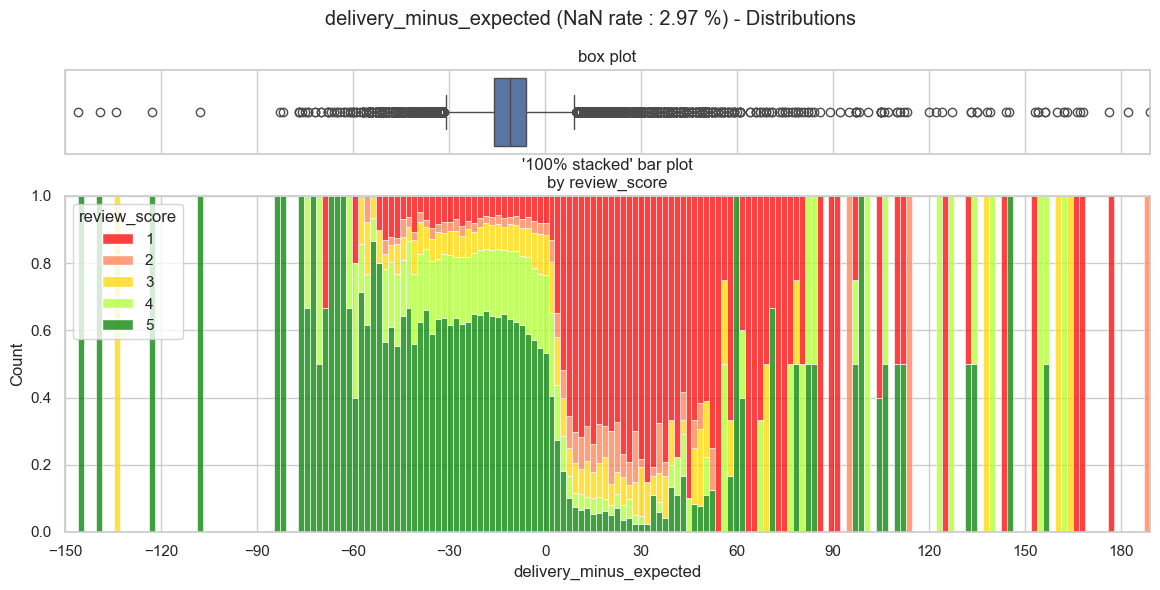

In [90]:
# draw two distributions of this difference : a boxplot and a stacked bar chart, by "review_score"

# create fig and both axes, a smaller one for the boxplot
fig, (ax_box, ax_reviews) = plt.subplots(
    2, 1, sharex=True, height_ratios=(1, 4), figsize=(14, 6)
)

# plot
sns.boxplot(data=diff_df, x="delivery_minus_expected", ax=ax_box)
sns.histplot(
    data=diff_df,
    x="delivery_minus_expected",
    bins=180,
    ax=ax_reviews,
    hue="review_score",
    element="bars",
    multiple="fill",
    palette=reviewColors,
)

# set xticks
ax_reviews.set_xticks(np.arange(-150, 210, step=30))
# set legend
sns.move_legend(obj=ax_reviews, loc="upper left")

# titles

# put NaN_rate in the title
nanRate = round(diff.isna().mean() * 100, 2)

fig.suptitle(
    "delivery_minus_expected (NaN rate : " + str(nanRate) + " %) - Distributions"
)
ax_box.set_title("box plot")
ax_reviews.set_title("'100% stacked' bar plot\nby review_score")

plt.show()

Nous retrouvons bien l'impact du retard sur la note du client : aux alentours de 0, la répartition des notes se retourne progessivement, **d'une majorité de bonnes notes vers une majorité de mauvaises**.

Nous voyons qu'à partir d'un mois de retard, les répartion devient plus erratique.
Un comportement similaire s'observe du côté des commandes ayant de l'avance.

Pour **réduire l'impact des outliers**, nous allons **borner à [-30,30]**.

Nous pourrons aussi **traiter nos valeurs manquantes** (correspondant à une absence de `order_delivered_customer_date`) en imputant avec notre nouvelle borne haute :

In [91]:
# keep only the rows where there is a delay
diff_df["delivery_minus_expected_CLIP"] = diff_df["delivery_minus_expected"].clip(
    -30, 30
)

In [92]:
# handle missing values
diff_df["delivery_minus_expected_CLIP"].fillna(30, inplace=True)

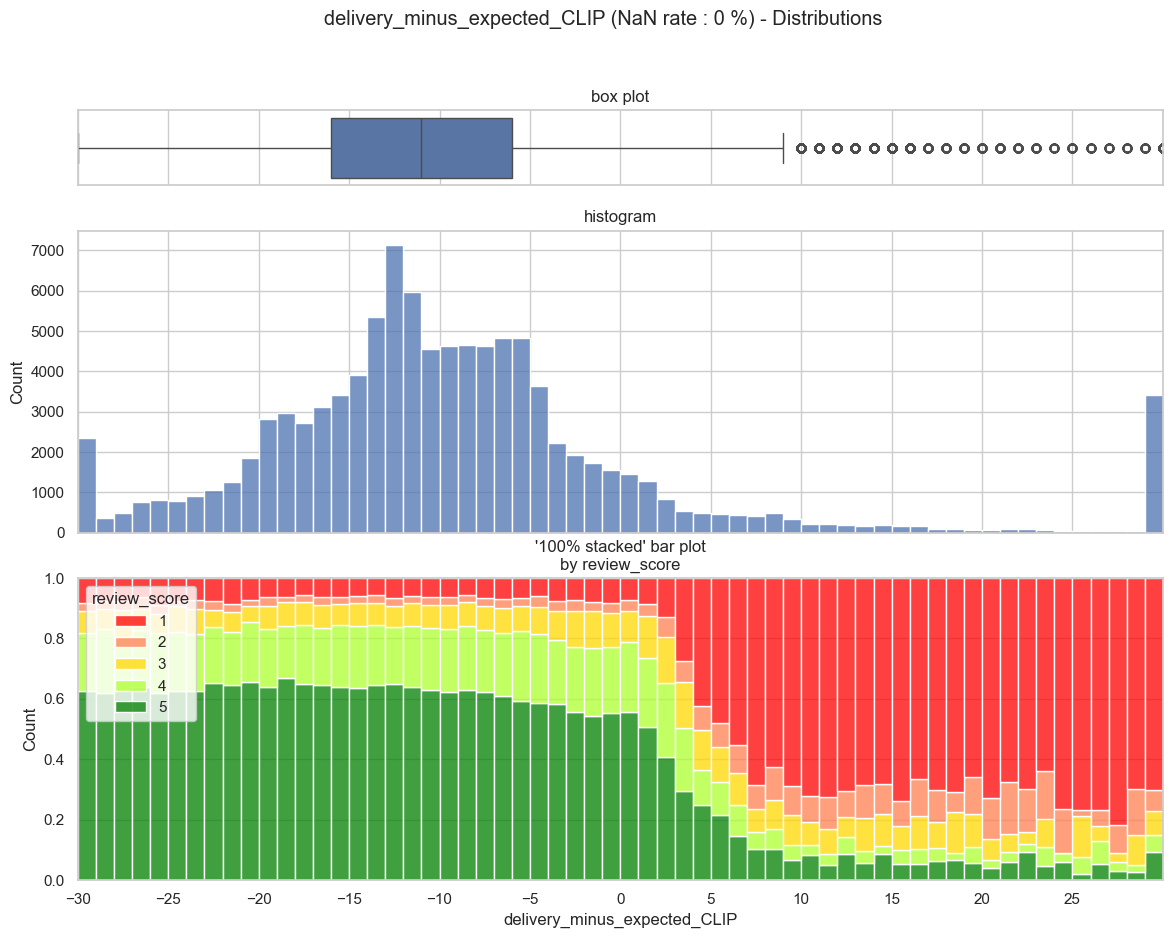

In [93]:
# draw the same three distributions

# create fig and both axes, a smaller one for the boxplot
fig, (ax_box, ax_hist, ax_reviews) = plt.subplots(
    3, 1, sharex=True, height_ratios=(1, 4, 4), figsize=(14, 10)
)

# plot
sns.histplot(
    data=diff_df,
    x="delivery_minus_expected_CLIP",
    bins=60,
    ax=ax_hist,
    # hue="review_score",element="step",multiple="fill",palette=reviewColors
)
sns.boxplot(data=diff_df, x="delivery_minus_expected_CLIP", ax=ax_box)
sns.histplot(
    data=diff_df,
    x="delivery_minus_expected_CLIP",
    bins=60,
    ax=ax_reviews,
    hue="review_score",
    element="bars",
    multiple="fill",
    palette=reviewColors,
)

# set xticks
ax_reviews.set_xticks(np.arange(-30, 30, step=5))
# set legend
sns.move_legend(obj=ax_reviews, loc="upper left")

# set titles

# put NaN_rate in the title
nanRate = int(diff_df["delivery_minus_expected_CLIP"].isna().mean() * 100)

fig.suptitle(
    "delivery_minus_expected_CLIP (NaN rate : " + str(nanRate) + " %) - Distributions"
)
ax_box.set_title("box plot")
ax_hist.set_title("histogram")
ax_reviews.set_title("'100% stacked' bar plot\nby review_score")


plt.show()

Nous pouvons maintenant intégrer cette nouvelle colonne dans notre dataset :

In [94]:
# add "delivery_minus_expected_CLIP" to our dataset
dataOrd["NEW_DELAY_DAYS"] = diff_df["delivery_minus_expected_CLIP"]

### 6.3.7) Récence : combien de temps écoulé depuis la commande ?

Nous allons créer une colonne nous permettant de **savoir si une commande a été effectuée il y a plus ou moins longtemps**.

Pour la **date de référence** : nous considérerons la date d'**achat la plus tardive** `order_purchase_timestamp`

In [95]:
# create a column with the time since purchase, relative to the most recent date of the dataset
dataOrd["NEW_RECENCE_MONTHS"] = (
    (dataOrd["order_purchase_timestamp"].max() - dataOrd["order_purchase_timestamp"])
    .round("d")
    .dt.days
)
# convert in months
dataOrd["NEW_RECENCE_MONTHS"] = dataOrd["NEW_RECENCE_MONTHS"] / 365 * 12
# round
dataOrd["NEW_RECENCE_MONTHS"] = round(dataOrd["NEW_RECENCE_MONTHS"], 2)

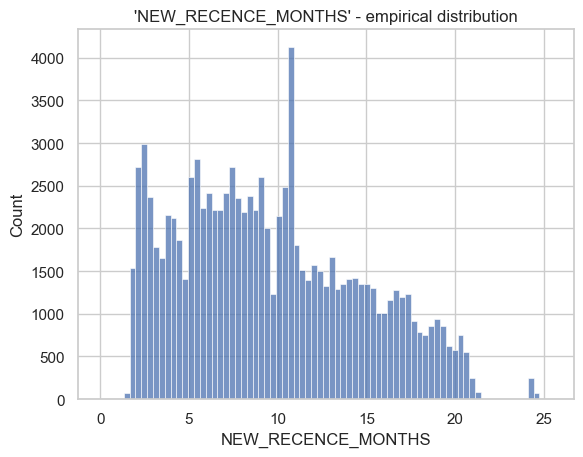

In [96]:
# draw the distribution of recense
sns.histplot(dataOrd["NEW_RECENCE_MONTHS"])
# title
plt.title("'NEW_RECENCE_MONTHS' - empirical distribution")

plt.show()

## 6.4) Les distances

Grâce aux données GPS, on peut s'intéresser à différentes distances :
- la distance qui sépare le client de la mediane des autres clients 
- la distance qui sépare le vendeur de la mediane des autres vendeurs
- la distance qui sépare le client du vendeur

In [97]:
%%time
# compute different distances
# first store mode coordonates
modCoord_CUS = (
    mf.myMode(dataOrd["geolocation_lat_CUS"]),
    mf.myMode(dataOrd["geolocation_lng_CUS"]),
)
modCoord_SEL = (
    mf.myMode(dataOrd["geolocation_lat_SEL"]),
    mf.myMode(dataOrd["geolocation_lng_SEL"]),
)

# add d(customer,seller)
dataOrd["NEW_Dist_CUS_SEL"] = dataOrd.apply(
    lambda r: geopy.distance.geodesic(
        (r["geolocation_lat_CUS"], r["geolocation_lng_CUS"]),
        (r["geolocation_lat_SEL"], r["geolocation_lng_SEL"]),
    ).km
    if r[
        [
            "geolocation_lat_CUS",
            "geolocation_lng_CUS",
            "geolocation_lat_SEL",
            "geolocation_lng_SEL",
        ]
    ]
    .notna()
    .all()
    else np.nan,
    axis=1,
)

# add d(customer,mode customers)
dataOrd["NEW_Dist_CUS_REST"] = dataOrd.apply(
    lambda r: geopy.distance.geodesic(
        (r["geolocation_lat_CUS"], r["geolocation_lng_CUS"]), modCoord_CUS
    ).km
    if r[["geolocation_lat_CUS", "geolocation_lng_CUS"]].notna().all()
    else np.nan,
    axis=1,
)

# add d(customer,mode customers)
dataOrd["NEW_Dist_SEL_REST"] = dataOrd.apply(
    lambda r: geopy.distance.geodesic(
        (r["geolocation_lat_SEL"], r["geolocation_lng_SEL"]), modCoord_SEL
    ).km
    if r[["geolocation_lat_SEL", "geolocation_lng_SEL"]].notna().all()
    else np.nan,
    axis=1,
)

CPU times: total: 30.5 s
Wall time: 2min 1s


On peut se demander si les retards de livraison sont liées aux distances :

C:\Users\cleme\anaconda3\envs\envProject5\Lib\site-packages\plotly\express\_core.py:2044: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


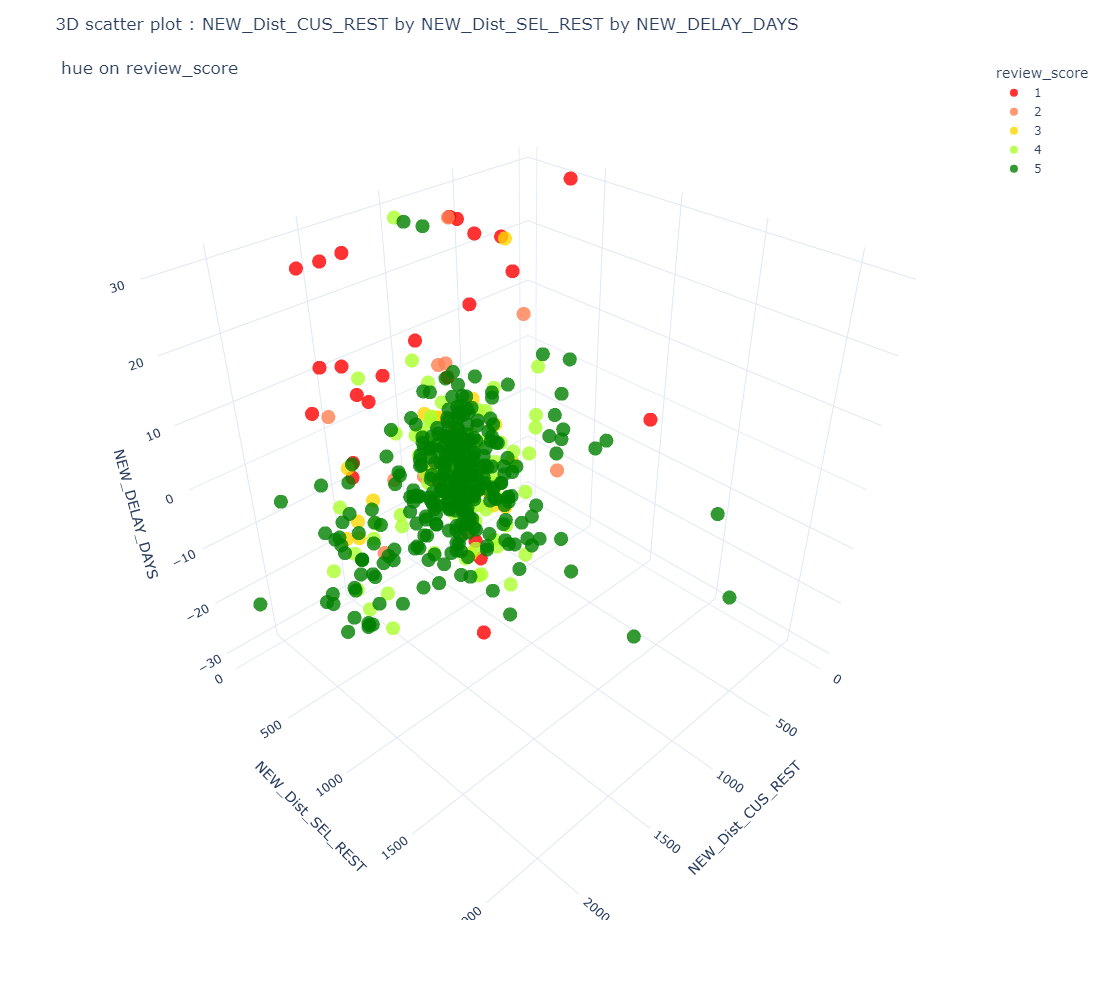

In [98]:
# use custom fonction myscatter3D

# first select needed columns
df = dataOrd[
    ["NEW_Dist_CUS_REST", "NEW_Dist_SEL_REST", "NEW_DELAY_DAYS", "review_score"]
].copy()

mf.myscatter3D(dataframe=df, sample=500, palette=reviewColors)

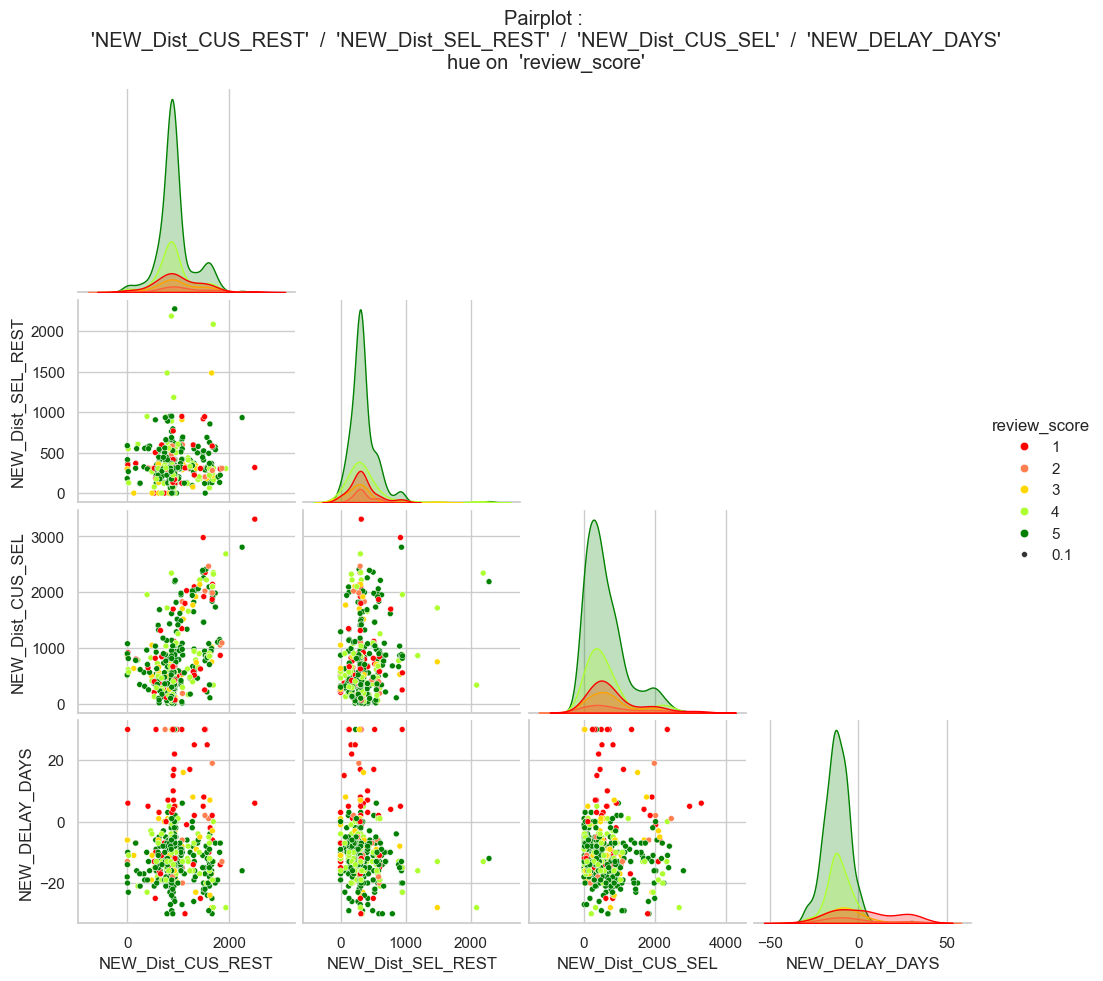

In [99]:
# pairplot of all "distance-like" columns, with hue on "review_score"

# add "NEW_Dist_CUS_SEL" to df
df["NEW_Dist_CUS_SEL"] = dataOrd["NEW_Dist_CUS_SEL"]
# change columns order
df = df[
    [
        "NEW_Dist_CUS_REST",
        "NEW_Dist_SEL_REST",
        "NEW_Dist_CUS_SEL",
        "NEW_DELAY_DAYS",
        "review_score",
    ]
]
# sample
df = df.sample(500)


# plot
g = sns.pairplot(
    data=df,
    hue="review_score",
    plot_kws={"size": 0.1},
    palette=reviewColors,
    corner=True,
)

# title

# add space on the top of the figure
g.fig.subplots_adjust(top=0.9)
# set title
g.fig.suptitle(
    "Pairplot : \n'NEW_Dist_CUS_REST'  /  'NEW_Dist_SEL_REST'  /  'NEW_Dist_CUS_SEL'  /  'NEW_DELAY_DAYS'\nhue on  'review_score'"
)

plt.show()

Cela ne semble pas être le cas. Nous retrouvons seulement le lien entre `review_score` et `NEW_DELAY_DAYS`.

## 6.5) Correlations

Nous pouvons nous intéresser aux correlations :

In [100]:
# compute correlation matrix

# create a copy
dfForCorr = dataOrd.copy()

# factorize ordinal column
for col in dfForCorr.columns:
    if dfForCorr[col].dtype.kind == "O":
        if dataOrd[col].cat.ordered == True:
            dfForCorr[col] = dfForCorr[col].cat.codes

# OHE category
dfForCorr = pd.get_dummies(
    dfForCorr, columns=["NEW_macro_product_category", "payment_type"], dtype=np.int8
)

# filter on numerical columns
numCols = [col for col in dfForCorr.columns if dfForCorr[col].dtype.kind in "biufmM"]
dfForCorr = dfForCorr[numCols]

In [101]:
# display correlation matrix using custom function
mf.displayHeatMapCorrMatrixWID(dfForCorr, figsize=(14, 14))

RadioButtons(description='Method : ', options=('pearson', 'kendall', 'spearman'), value='pearson')

Output()

Le coefficient de Pearson ne semble pas très indiqué (plus adéquat pour des relations linéaires). 
De plus, eu égard à la présence d'outliers, le coefficient de correlation de Kendall est plus approprié que le coefficient de Spearman.

Ce que l'ont peut en retenir, logiquement, sont des liens :
- entre les différentes features de type "datetime" ou créées à partir de celles-ci
- entre les distances créées et les frais des livraion
- entre le paiement et le prix
- entre la masse et le volume du produit
- etc.set

## 6.6) Les valeurs manquantes

### 6.6.1) État des lieux des valeurs manquantes

Regardons l'impact des jointures sur les valeurs manquantes :

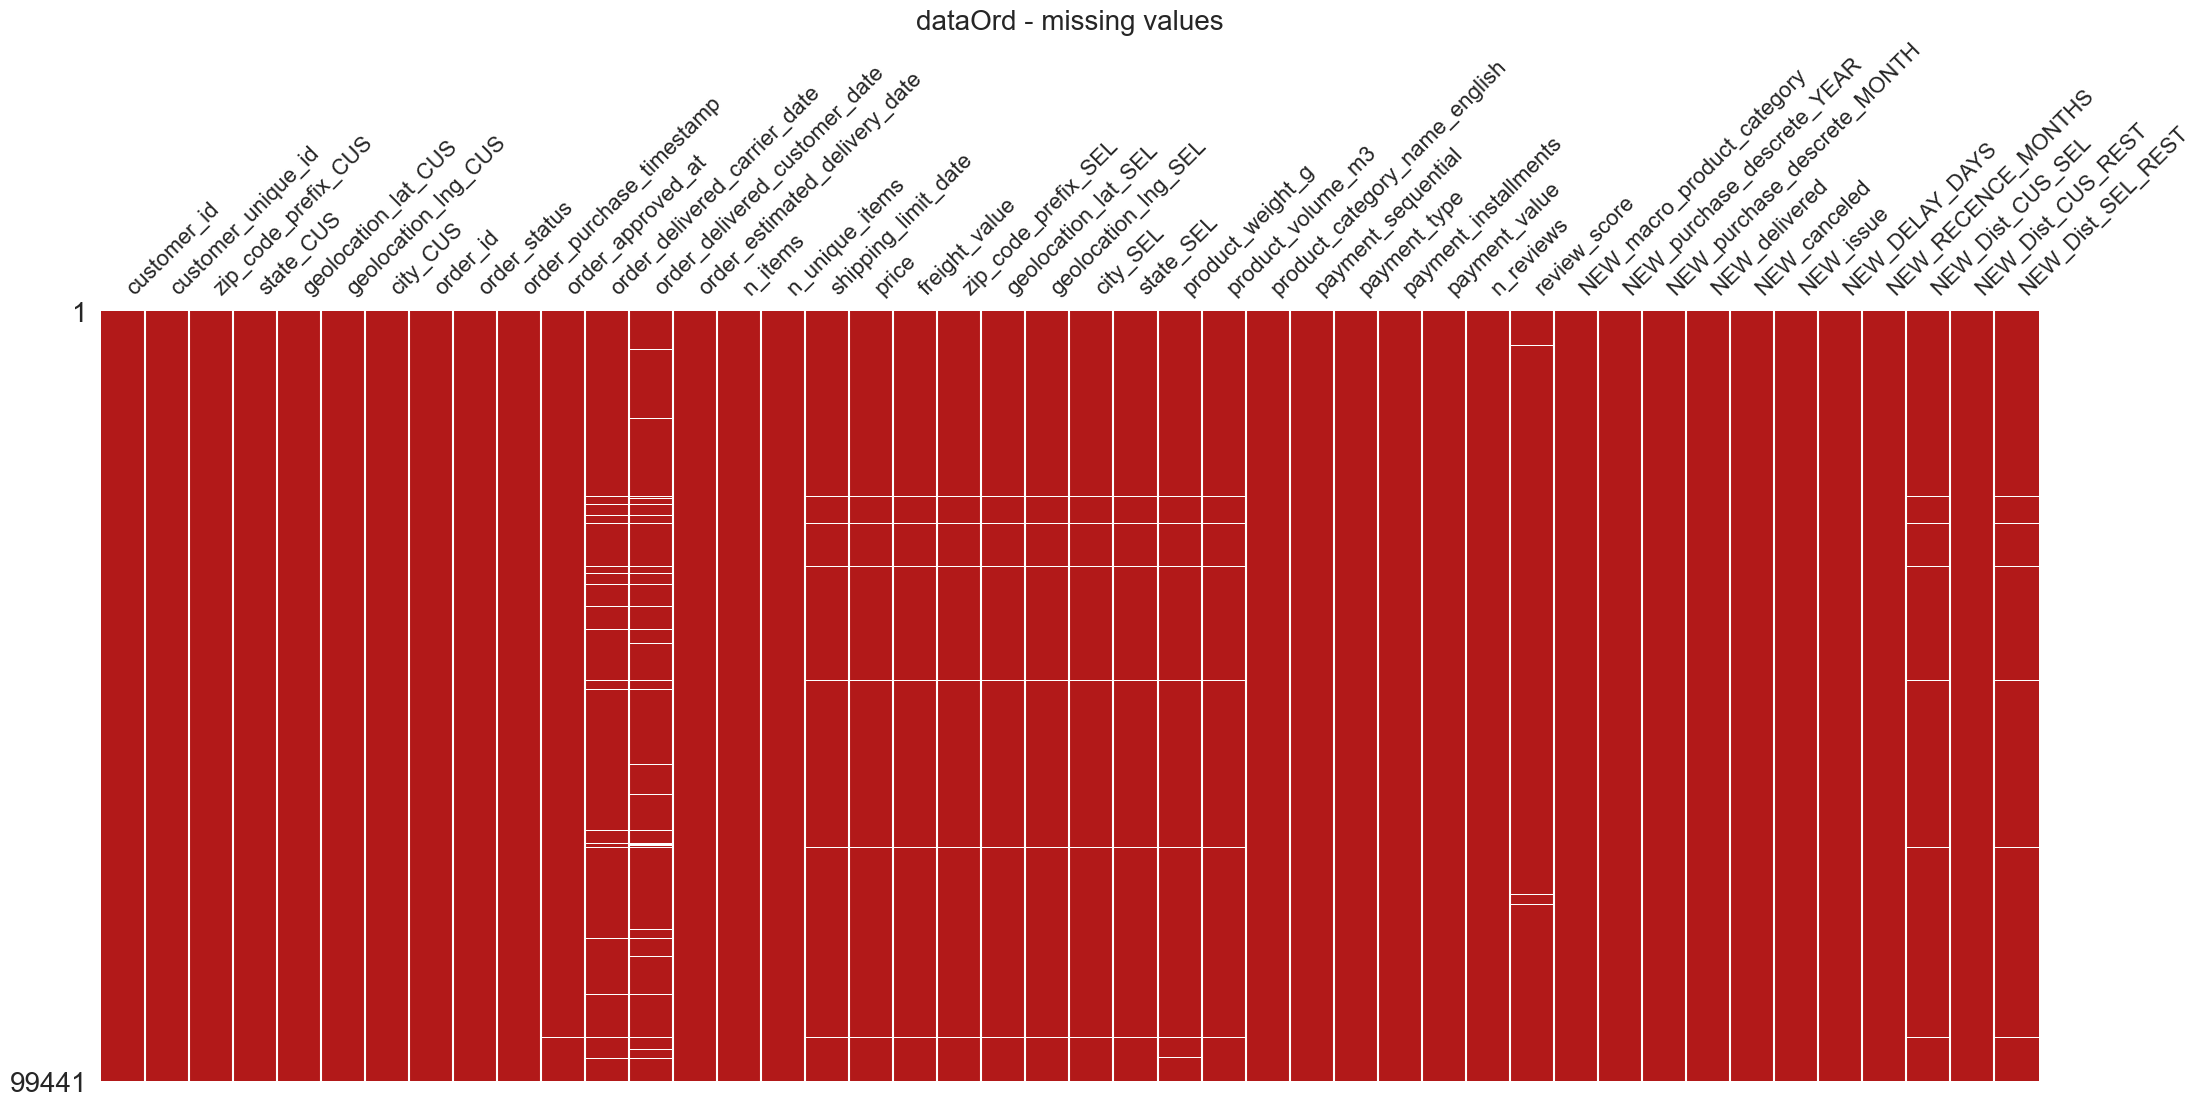

In [102]:
# use missingno matrix function to plot dataOrd missingness
ms.matrix(dataOrd, sparkline=False, color=(0.7, 0.1, 0.1))
# add title
plt.title("dataOrd - missing values", fontsize=20)
plt.show()

Comme anticipé, suite aux jointures, certains groupes de features ont hérité de valeurs manquantes dû à des problèmes de concordance.

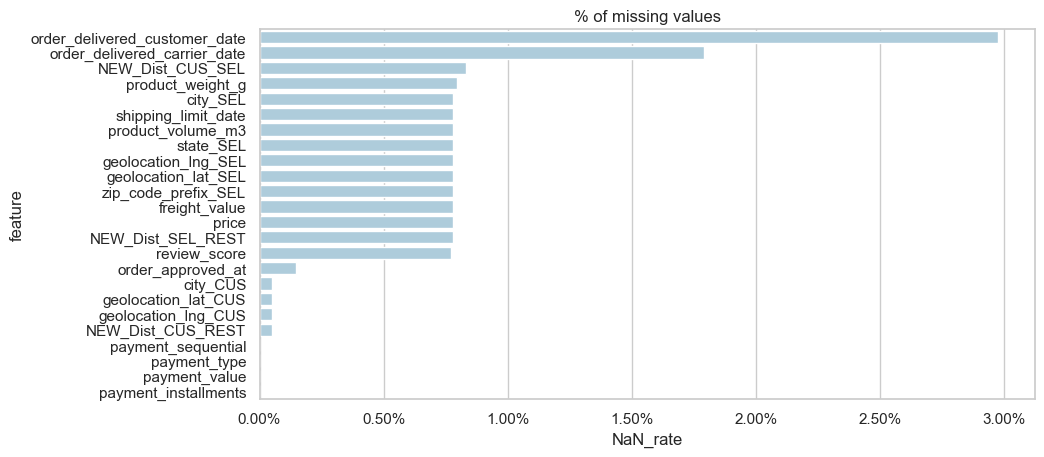

In [103]:
# store data NaN rates, sort them and keep only non null ones
nanVals = dataOrd.isna().mean() * 100
nanVals = nanVals.sort_values(ascending=False)
nanVals = nanVals[nanVals > 0]

# put feature names in a column
nanVals = nanVals.reset_index(name="NaN_rate")
nanVals.rename(columns={"index": "feature"}, inplace=True)

# create a figure, adjusting height proportionally to the number of columns
fig, ax = plt.subplots(1, 1, figsize=(10, 0.20 * len(nanVals)))
sns.barplot(
    data=nanVals, x="NaN_rate", y="feature", ax=ax, color=sns.color_palette("Paired")[0]
)

# x axis in percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# add title
ax.set_title("% of missing values")

plt.show()

Nous retrouvons les taux initialement présents dans :
- `orders` pour `order_delivered_customer_date`, `order_delivered_carrier_date` et `order_approved_at`,
- `customersGeo` pour `city_CUS`, `geolocation_lat_CUS` et `geolocation_lng_CUS` (certaines ont déjà été traitées)

Les autres valeurs sont logiques et avait été anticipées lors de l'étude du niveau de correspondance entre les datasets :
- `orders` et `items` (et donc `products` et `sellers`)
- `orders` et `reviews`

### 6.6.2) Imputer `freight_value`, `price` et `payment_value`

Afin d'imputer simplement, mais logiquement, ces colonnes nous allons appliquer la relation : <br><center>$(prix+livraison) * Narticles = paiement$.

In [104]:
# store "freight_value", "price" and "payment_value" for before/after analysis
oldMoneyDf = dataOrd[["freight_value", "price", "payment_value"]]

In [105]:
# store necessary columns names
moneyCols = ["n_items", "n_unique_items", "freight_value", "price", "payment_value"]

Tout d'abord, regardons si cette équation se vérifie en recherchant les observations où il existe une différent de plus de 5% entre ses deux termes :

In [106]:
# filter on non missing values
mask1 = dataOrd[moneyCols].notna().all(axis=1)

# filter where the difference ("price" - "freight_value") - "payment_value" is above 5% in absolute value
mask2 = (
    abs(
        dataOrd["n_items"] * dataOrd[["price", "freight_value"]].sum(axis=1)
        - dataOrd["payment_value"]
    )
    / dataOrd["payment_value"]
    > 0.05
)

# apply filters
dataOrd.loc[mask1 & mask2, moneyCols]

n_items  n_unique_items  freight_value   price  payment_value
1812       1.0             1.0          19.60   58.90          90.67
2810       1.0             1.0          25.63   50.00          80.90
3244       1.0             1.0          14.52   36.99          56.96
3251       1.0             1.0          49.18  249.00         318.96
4394       1.0             1.0          17.67   59.90          82.98
...        ...             ...            ...     ...            ...
96154      1.0             1.0          21.15   32.99          61.19
97544      1.0             1.0          15.23   12.99          31.89
97560      1.0             1.0          25.63   27.75          60.35
98104      1.0             1.0          22.28   44.50          75.49
98746      1.0             1.0          15.38   89.50         130.00

[216 rows x 5 columns]

Il ne semble pas y avoir de problème important (avec une différence supérieure à 5%).

Regardons si nous pouvons simplement imputer `payment_value` avec notre équation :

In [107]:
# filter on "payment_value" missing values
mask = dataOrd["payment_value"].isna()
dataOrd.loc[mask, moneyCols]

n_items  n_unique_items  freight_value  price  payment_value
21125      3.0             1.0           2.83  44.99            NaN

Les autres colonnes étant renseignées dans cet unique cas, nous pouvons imputer facilement :

In [108]:
dataOrd.loc[mask, "payment_value"] = (
    dataOrd.loc[mask, ["freight_value", "price"]].sum(axis=1)
    * dataOrd.loc[mask, "n_items"]
)

Pour `freight_value` et `price`, nous allons travailler en deux étapes :
- déterminer le rapport moyen entres elles pour pouvoir écrire `freight_value` en fonction de `price`. Il s'agit d'**une grosse approximation** mais nous n'avons pas à disposition les features qui nous permettrait de faire mieux (`volume`, `weigth`, les `xxx_SEL`, etc.).
  <br><center>$prix = paiement / (N(1 + ratio))$
- utiliser l'équation pour imputer `price`, puis `freight_value`

Mais d'abord, regardons les cas à traiter :

In [109]:
# filter on "payment_value" missing values
mask = dataOrd[["freight_value", "price"]].isna().any(axis=1)
dataOrd.loc[mask, moneyCols]

n_items  n_unique_items  freight_value  price  payment_value
46         1.0             1.0            NaN    NaN          73.16
288        1.0             1.0            NaN    NaN         174.54
373        1.0             1.0            NaN    NaN         117.78
383        1.0             1.0            NaN    NaN          66.02
556        1.0             1.0            NaN    NaN          46.69
...        ...             ...            ...    ...            ...
98267      1.0             1.0            NaN    NaN         615.53
98319      1.0             1.0            NaN    NaN         112.91
98551      1.0             1.0            NaN    NaN          92.76
98642      1.0             1.0            NaN    NaN         136.50
99105      1.0             1.0            NaN    NaN          66.42

[775 rows x 5 columns]

In [110]:
# compute the average  `freight_value` `price` ratio
ratio = (dataOrd["freight_value"] / dataOrd["price"]).mean(skipna=True)
ratio
# impute `price`
dataOrd.loc[mask, "price"] = dataOrd.loc[mask, "payment_value"] / (
    dataOrd.loc[mask, "n_items"] * (1 + ratio)
)
# impute `freight_value`
dataOrd.loc[mask, "freight_value"] = ratio * dataOrd.loc[mask, "price"]

Voici le résultat :

In [111]:
# look at the same observations, this time imputed
dataOrd.loc[mask, moneyCols]

n_items  n_unique_items  freight_value       price  payment_value
46         1.0             1.0      17.243894   55.916106          73.16
288        1.0             1.0      41.139275  133.400725         174.54
373        1.0             1.0      27.760879   90.019121         117.78
383        1.0             1.0      15.560988   50.459012          66.02
556        1.0             1.0      11.004886   35.685114          46.69
...        ...             ...            ...         ...            ...
98267      1.0             1.0     145.081114  470.448886         615.53
98319      1.0             1.0      26.613014   86.296986         112.91
98551      1.0             1.0      21.863636   70.896364          92.76
98642      1.0             1.0      32.173204  104.326796         136.50
99105      1.0             1.0      15.655269   50.764731          66.42

[775 rows x 5 columns]

### 6.6.3) Imputer `review_score`

Pour le `review_score`, l'idée est de :
- faire mieux qu'une imputation par `3` (la note moyenne) ou par la médiane
- transformer notre **problème d'imputation en problème de classification multiclasses** et utiliser un modèle de machine learning
- faire au plus simple, avec un **modèle pas forcémment optimisé**
- partir du dataframe `dfForCorr`, qui ne contient que :
    - les features **numériques**,
    - les features considérées comme ordinales, **encodées**,
    - quelques features nominales, **encodées**

In [112]:
# create an classification model to impute "review_score"

# filter on "nonTime" columns
X = dfForCorr[
    [col for col in dfForCorr.columns if dfForCorr[col].dtype.kind in "if"]
].copy()

# drop "review_score", the target
X.drop(columns="review_score", inplace=True)
# target
y = dataOrd["review_score"].copy()

# split between rows on which we will need to impute "review_score", and the rows we will use for training
maskYNan = y.isna()
XTrain, yTrain = X.loc[~maskYNan], y.loc[~maskYNan]
XToImp, yToImp = X.loc[maskYNan], y.loc[maskYNan]

# model

# imputer
imputer = SimpleImputer(strategy="median")
# model
clf = LGBMClassifier(
    class_weight="balanced",
    n_jobs=16,
    objective="multiclass",
    colsample_bytree=0.8,
    subsample=0.5,
    n_estimators=1000,
    learning_rate=0.05,
    random_state=16,
)
# pipeline
pipe = Pipeline([("imputer", imputer), ("clf", clf)])

# fit
pipe.fit(XTrain, yTrain)

# extract feature importances
importance = pd.DataFrame()
importance["feat"] = list(pipe["imputer"].get_feature_names_out())
importance["importance"] = pipe["clf"].feature_importances_
# sort values by feature importance
importance = importance.sort_values("importance")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3501
[LightGBM] [Info] Number of data points in the train set: 98673, number of used features: 38
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


On peut regarder l'importance des features :

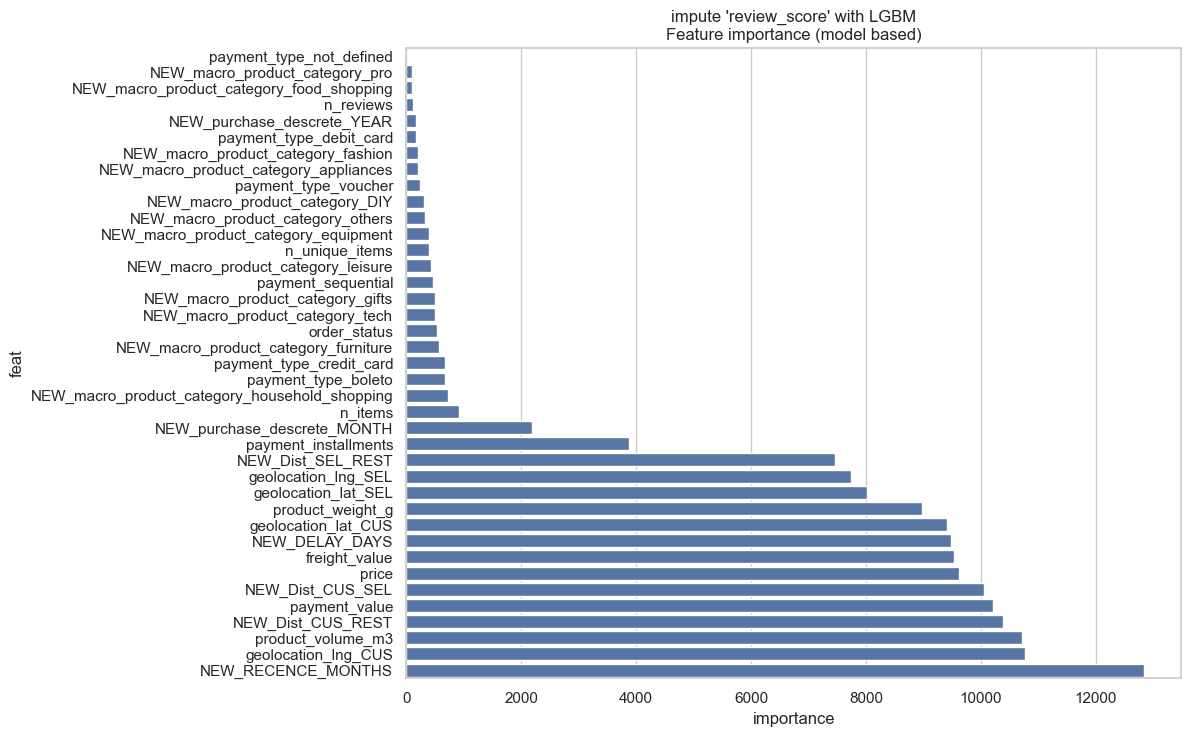

In [113]:
# plot feature importances

# on a barplot
fig, ax = plt.subplots(1, figsize=(10, 0.21 * len(importance)))
sns.barplot(data=importance, y="feat", x="importance")

# title
ax.set_title("impute 'review_score' with LGBM\nFeature importance (model based)")

plt.show()

Regardons la **matrice de confusion** issue de **prédictions par validation croisée** :

In [114]:
# cross validation predictions
yPreds = cross_val_predict(
    estimator=pipe, X=XTrain, y=yTrain, cv=StratifiedKFold(n_splits=5)
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3497
[LightGBM] [Info] Number of data points in the train set: 78938, number of used features: 38
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3500
[LightGBM] [Info] Number of data points in the train set: 78938, number of used features: 38
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score 

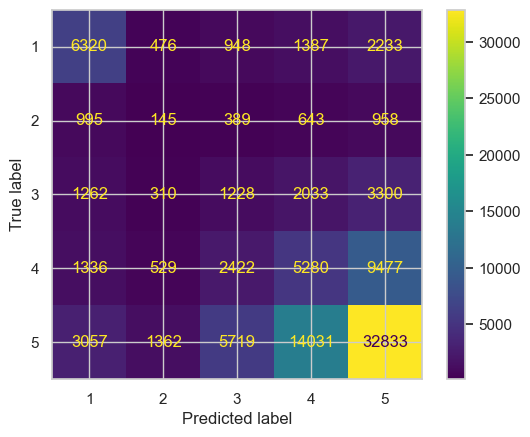

In [115]:
# draw confusion matrix
ConfusionMatrixDisplay.from_predictions(y_pred=yPreds, y_true=yTrain)

Les résultats ne sont pas très bon... Nous pouvons confirmer cela en calculant le `f1-score` (`macro` - pour donner autant d'importance à chaque classe ) :

In [116]:
# compute macro f1 score
print("f1-score - macro : ", f1_score(y_true=yTrain, y_pred=yPreds, average="macro"))

f1-score - macro :  0.3136247479982785


Les résultats sont mitigés, mais le modèle n'a pas vraiment été optimisé. Cela sera suffisant pour notre problème :

In [117]:
# predict missing y
yImp = pipe.predict(X=XToImp)

# impute dataOrd
dataOrd.loc[yToImp.index, "review_score"] = yImp

### 6.6.4) Bilan des imputations

Mettons à jour notre tableau des valeurs manquantes :

C:\Users\cleme\AppData\Local\Temp\ipykernel_2784\3390195105.py:21: UserWarning:

The palette list has more values (12) than needed (2), which may not be intended.



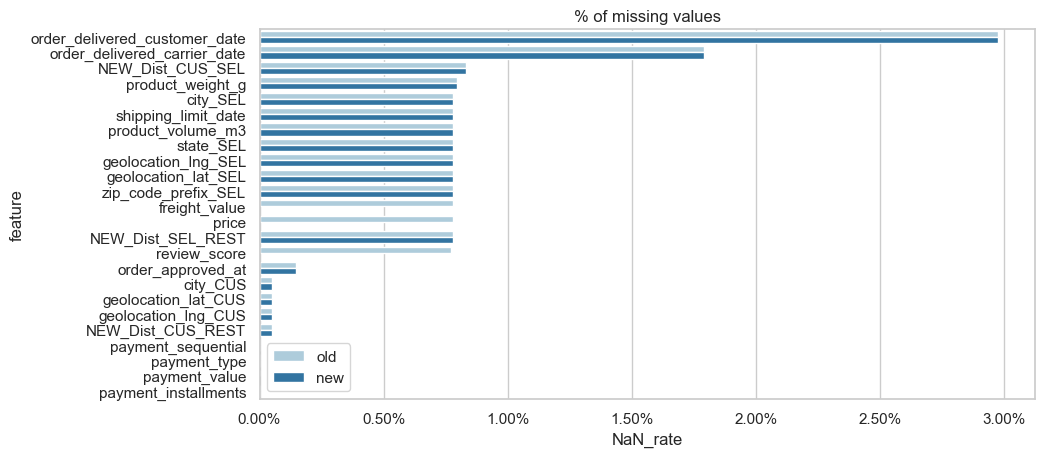

In [118]:
# store data NaN rates, sort them and keep only non null ones
newNanVals = dataOrd.isna().mean() * 100
newNanVals = newNanVals.sort_values(ascending=False)
newNanVals = newNanVals[newNanVals > 0]

# rename the "NaN_rate" column in nanVals
NanValsUpdate = nanVals.copy()
NanValsUpdate.rename(columns={"NaN_rate": "old"}, inplace=True)

# add the new values
for col in newNanVals.index:
    NanValsUpdate.loc[NanValsUpdate["feature"] == col, "new"] = newNanVals.loc[col]


NanValsUpdate = NanValsUpdate.melt(
    id_vars="feature", value_vars=["old", "new"], var_name="", value_name="NaN_rate"
)

# create a figure, adjusting height proportionally to the number of columns
fig, ax = plt.subplots(1, 1, figsize=(10, 0.20 * len(nanVals)))
sns.barplot(
    data=NanValsUpdate,
    x="NaN_rate",
    y="feature",
    ax=ax,
    palette=sns.color_palette("Paired"),
    hue="",
)

# x axis in percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# add title
ax.set_title("% of missing values")

plt.show()

# 7) Exporter nos données

Maintenant que notre exploration est terminée, nous pouvons exporter notre jeu de données regroupant nos informations par commande. Nous pourrons l'utiliser par la suite pour :
- extraire des features nécessaires à notre problème de segmentation
- les agréger par client (`customer_unique_id`)
- tester différents modèles de segmentation

In [119]:
# export "dataOrd"
dump(dataOrd, "mySaves/dataset_by_orders/dataOrd.joblib")

['mySaves/dataset_by_orders/dataOrd.joblib']

In [120]:
# compute execution time
end_time = time.time()
print("execution time :", int((end_time - start_time) / 60), "min.")

execution time : 7 min.
